In [2]:
base_dir="/mnt/efs/shared/meg_shared_scripts/meg-kb"
data_ac="indeeda-meg-ac"
data_pt="indeeda-meg-pt"
yutong_base_dir="/home/ubuntu/users/yutong"

In [3]:
%cd $base_dir/src/concept_learning/

/mnt/efs/shared/meg_shared_scripts/meg-kb/src/concept_learning


In [282]:
from tqdm.notebook import tqdm
import argparse
import re
import numpy as np
from scipy.spatial.distance import cosine
from scipy.stats import pearsonr, entropy, gmean
import random
import torch
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import BertTokenizer, BertModel, BertForMaskedLM
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import json
from collections import defaultdict
import time

import logging
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.manifold import TSNE
import pandas as pd
import os
import sys
import math
from annoy import AnnoyIndex
import matplotlib
from matplotlib import pyplot as plt
import networkx as nx

import spacy
from spacy.lang.en import English
nlp = English()
nlp.add_pipe(nlp.create_pipe('sentencizer'))
spacy_tokenizer = nlp.tokenizer

from compute_concept_clusters import knn
from compute_keyphrase_embeddings import ensure_tensor_on_device, mean_pooling

from utils import LMProbe, LMProbe_GPT2
from utils import load_embeddings, load_seed_aligned_concepts, load_seed_aligned_relations, load_benchmark
from utils import get_masked_contexts

from roberta_ses.interface import Roberta_SES_Entailment

In [5]:
seed_concepts_path = os.path.join(base_dir, f'data/indeed-benchmark/seed_concepts.csv')
seed_relations_path = os.path.join(base_dir, f'data/indeed-benchmark/seed_relations.csv')

seed_aligned_concepts_path = os.path.join(base_dir, f'data/indeed-benchmark/seed_aligned_concepts.csv')
seed_aligned_relations_path = os.path.join(base_dir, f'data/indeed-benchmark/seed_aligned_relations.csv')

# Data Preprocessing

In [2]:
# Input: text corpus
# step 1: extract key phrases (autophrase)
# step 2: generate embeddings

## Extract Key Phrases

In [3]:
# details here: https://github.com/rit-git/meg-kb/tree/main/src/keyword_extraction

In [8]:
#change to keyword extractor directory
%cd $base_dir/src/keyword_extraction/

/mnt/efs/shared/meg_shared_scripts/meg-kb/src/keyword_extraction


In [9]:
!chmod +x ./corpusProcess.sh

In [5]:
# select the dataset and thread no
data_ac = 'indeeda-meg-ac'
data_pt = 'indeeda-meg-pt'
thread = 8

In [463]:
# process corpus and generate key prhases
!./corpusProcess.sh $data_ac $thread

/mnt/efs/shared/meg_shared_scripts/meg-kb/src/keyword_extraction
===Corpus Name: sample-indeeda-meg-ac===
===Current Path: /mnt/efs/shared/meg_shared_scripts/meg-kb/src/keyword_extraction===
===Cleaning input corpus===
===Running AutoPhrase===
make: Nothing to be done for 'all'.
===RAW_TRAIN: ../../../data/sample-indeeda-meg-ac/source/corpus.clean.txt===
auto_phrase.sh parameters: sample-indeeda-meg-ac ../../../data/sample-indeeda-meg-ac/source/corpus.clean.txt 10 data/EN/wiki_quality.txt 8
===Compilation===
===Tokenization===
Current step: Tokenizing input file...
real	0m0.702s
user	0m1.668s
sys	0m0.100s
Detected Language: EN
Current step: Tokenizing wikipedia phrases...
No provided expert labels.
===Part-Of-Speech Tagging===
===AutoPhrasing===
=== Current Settings ===
Iterations = 2
Minimum Support Threshold = 10
Maximum Length Threshold = 6
POS-Tagging Mode Disabled
Discard Ratio = 0.050000
Number of threads = 8
Labeling Method = DPDN
	Auto labels from knowledge bases
	Max Positive 

In [464]:
# copy these results to sample-meg-pt
!cp -r ../../data/$data_ac ../../data/$data_pt

## Corpus with company names

In [33]:
dataset_path = '/home/ubuntu/users/nikita/data/indeed/indeedQA/question_answers.csv'
company_path = '/home/ubuntu/users/nikita/data/indeed/indeedQA/fccid-companyName.csv'
entity_emb_num_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/BERTembednum+seeds.txt')
out_corpus_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/sentences_with_company.json')

In [34]:
with open(entity_emb_num_path, 'r') as f:
    entities = [l.strip().rsplit(' ', 1)[0] for l in f.readlines()]
len(entities)

8053

In [ ]:
df_dataset = pd.read_csv(dataset_path) 
df_dataset = df_dataset[df_dataset['answerContent'].notna()]
df_company = pd.read_csv(company_path)

df_merged_dataset = df_dataset.merge(df_company, how='inner', on='fccompanyId')
df_merged_dataset.head(10)

In [36]:
df_merged_dataset.shape

(307122, 11)

In [37]:
row = df_merged_dataset.iloc[1]
_d = nlp(row["answerContent"])
list(_d.sents)
list(list(_d.sents)[0])

[I, applied, online, and, submitted, all, attachments, that, I, could, .]

In [ ]:
out_corpus = []

for i, row in df_merged_dataset.iterrows():
    if i > 0 and i % 5000 == 0:
        print(f'Progress: {i} / {df_merged_dataset.shape[0]}')
    
    company = row["companyName"]
    ans = row["answerContent"]
    ans_nlp = nlp(ans)
    for sent in ans_nlp.sents:
        sent_tok_list = [str(t) for t in sent]
        _s = f' {company} : {" ".join(sent_tok_list)} '.lower()
        _ents = []
        for _e in entities:
            if f' {_e} ' in _s:
                _ents.append(_e)
        out_corpus.append({
            "tokens": sent_tok_list,
            "company": company,
            "entities": _ents,
        })

In [ ]:
len(out_corpus), out_corpus[0]

In [43]:
with open(out_corpus_path, 'w') as f:
    for d in out_corpus:
        f.write(json.dumps(d) + '\n')

In [42]:
# Use script
!python build_corpus_with_companies.py \
-d $base_dir/data/$data_ac/intermediate \
-b $base_dir/data/indeed-benchmark \
-rd /home/ubuntu/users/nikita/data/indeed/indeedQA


Processing lines: 100%|████████████████| 307122/307122 [11:51<00:00, 431.47it/s]


# Generate Embeddings

In [465]:
# details here: https://github.com/rit-git/meg-kb/tree/main/src/concept_learning

In [11]:
#change to concept learning directory
%cd $base_dir/src/concept_learning/

/mnt/efs/shared/meg_shared_scripts/meg-kb/src/concept_learning


## Sentence Embedding

In [467]:
!python compute_keyphrase_embeddings.py -m bert-base-uncased -et ac -d ../../data/$data_ac/intermediate -c 750

computing entity-wise embedding: 100%|████████| 177/177 [00:03<00:00, 50.59it/s]
Saving embedding


## Concatenated Token Embedding

In [468]:
!python compute_keyphrase_embeddings.py -m bert-base-uncased -et pt -d ../../data/$data_pt/intermediate -c 750

computing entity-wise embedding: 100%|████████| 177/177 [00:03<00:00, 53.88it/s]
Saving embedding


## Token Embedding

In [469]:
# change directory to autophrase
%cd $base_dir/src/tools/AutoPhrase

/mnt/efs/shared/meg_shared_scripts/meg-kb/src/tools/AutoPhrase


In [470]:
data_corel = 'sample-indeeda-corel'

In [471]:
!CUDA_VISIBLE_DEVICES=0 python extractBertEmbedding.py ../../../data/$data_corel/intermediate/ $thread

1
2021-06-18 00:36:18,384 : INFO : loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /home/ubuntu/.cache/torch/pytorch_transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
2021-06-18 00:36:18,776 : INFO : loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /home/ubuntu/.cache/torch/pytorch_transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.7156163d5fdc189c3016baca0775ffce230789d7fa2a42ef516483e4ca884517
2021-06-18 00:36:18,777 : INFO : Model config {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embedding

## Add embeddings for seed instances

In [13]:
def get_masked_contexts_for_entities(entities, input_file):
    """Return a (list of) sentence(s) with entity replaced with MASK."""
    """YS: input should be sentences.json"""
    
    ent_freq = {ent : 0 for ent in entities}
    ent_context = {ent : [] for ent in entities}
    
    with open(input_file, "r") as fin:
        lines = fin.readlines()
        for line in tqdm(lines, total=len(lines), desc="loading corpus"):
            json_dict = json.loads(line)
            sent = ' ' + ' '.join(json_dict['tokens']).lower() + ' '
            #entities = [match.group(1) for match in re.finditer(pat, line)]
            
            for entity in entities:
                pat = f' {entity} '
                if pat not in sent:
                    continue

                context = sent.replace(pat, ' [MASK] ').strip()
                c = context.split('[MASK]')
                if len(c) != 2:  # sanity to not have too many repeating phrases in the context
                    continue

                # ignore too short contexts
                if len(context) < 15:
                    continue

                # print(entity)
                # print(context)
                
                _freq = ent_freq.get(entity, 0)
                ent_freq[entity] = _freq + 1

                context_lst = ent_context.get(entity, [])
                context_lst.append(context)
                ent_context[entity] = context_lst

    dedup_context = {}
    for e, v in ent_context.items():
        dedup_context[e] = list(set(v))
    return ent_freq, dedup_context


In [14]:
def get_avg_context_embedding_for_entities(entities, model_path, input_file, max_context_ct):
    '''
    mean pooling from sentence-transformers
    :param entity: List[str], the entities to compute embeddings for
    :param model_path:
    :param input_file:
    :return:
    '''
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModel.from_pretrained(model_path)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    mask_token_id = tokenizer.mask_token_id

    ent_freq, ent_context = get_masked_contexts_for_entities(entities, input_file)
    
    entity_embeddings = {}
    for entity, en_context_lst in tqdm(ent_context.items(), total=len(ent_context), desc="computing entity-wise embedding"):
#     for entity, en_context_lst in ent_context.items():
        print(entity)
        en_context_lst = random.sample(en_context_lst, min(len(en_context_lst), max_context_ct))
        chunks = [en_context_lst[i:i + 100] for i in range(0, len(en_context_lst), 100)]
        # print(entity)
        # print(len(en_context_lst))
        all_context_embeddings = []
        for chunk in chunks:
            encoded_input = tokenizer.batch_encode_plus(chunk, return_token_type_ids=True, add_special_tokens=True, max_length=128, return_tensors='pt', padding=True, pad_to_max_length=True, truncation=True)
            mask = encoded_input['input_ids'] != mask_token_id
            with torch.no_grad():
                encoded_input = ensure_tensor_on_device(device, **encoded_input)
                model_output = model(**encoded_input)  # Compute token embeddings
            context_embeddings = mean_pooling(model_output, mask)  # mean pooling
            all_context_embeddings.append(context_embeddings)
            
        assert len(all_context_embeddings) > 0
            
        entity_embedding = torch.mean(torch.cat(all_context_embeddings, dim=0), dim=0).cpu().detach().numpy().tolist()
        entity_embeddings[entity] = entity_embedding
    
    return entity_embeddings, ent_freq

In [ ]:
corpus_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/sentences.json')
seed_aligned_concepts_path = os.path.join(base_dir, f'data/indeed-benchmark/seed_aligned_concepts.csv')

orig_bert_emb_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/BERTembed.txt')
orig_bert_emb_num_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/BERTembednum.txt')

new_bert_emb_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/BERTembed+seeds.txt')
new_bert_emb_num_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/BERTembednum+seeds.txt')

orig_emb_df = load_embeddings(bert_emb_path, 768)
emb_dict = dict(zip(orig_emb_df['entity'].to_list(), orig_emb_df['embedding'].to_list()))

with open(orig_bert_emb_num_path, 'r') as f:
    lines = f.readlines()
    emb_freq_dict = dict([l.strip().rsplit(' ', 1) for l in lines])

concepts_df = load_seed_aligned_concepts(seed_aligned_concepts_path)
seed_instances_list = [inst for _, (_a_con, _u_con, _gnrl, _seed_instances) in concepts_df.iterrows()
                           for inst in _seed_instances]

## debug
seed_instances_list = seed_instances_list[::10]

print(seed_instances_list)

entity_embeddings, ent_freq = \
    get_avg_context_embedding_for_entities(entities=seed_instances_list, 
                                           model_path='bert-base-uncased',
                                           input_file=corpus_path,
                                           max_context_ct=750)

In [ ]:
for inst in seed_instances_list:
    emb = entity_embeddings[inst]
    freq = ent_freq[inst]
    if inst in emb_dict:
        print(f'Already exists: {inst}')
#         assert np.allclose(emb_dict[inst], emb)
#         assert emb_freq_dict[inst] == freq, f'{inst}: orig {emb_freq_dict[inst]} != new {freq}'
#         print(f'Check passed: {inst}')
    else:
        emb_dict[inst] = emb
        emb_freq_dict[inst] = freq

In [ ]:
entity_embeddings.keys()

In [ ]:
with open(new_bert_emb_path, 'w') as f, open(new_bert_emb_num_path, 'w') as f2:
    for inst in seed_instances_list:
        emb = emb_dict[inst]
        freq = ent_freq[inst]
        f.write("{} {}\n".format(inst, ' '.join([str(x) for x in emb])))
        f2.write("{} {}\n".format(inst, freq))


In [735]:
# Using script

!python add_seed_instances_embeddings.py -m bert-base-uncased -et ac -d $base_dir/data/$data_ac/intermediate -b $base_dir/data/indeed-benchmark -c 750


Seed instances: ['walmart', 'amazon', 'subway', 'microsoft', 'target', 'business casual', 'uniform', 'hair color', 'tattoos', 'facial hair', 'shoes', 'piercings', 'delivery driver', 'store manager', 'cashier', 'package handler', 'sales associate', 'barista', 'dishwasher', 'weekly', 'biweekly', 'friday', 'saturday', 'health insurance', 'flexible schedule', '401k', 'paid vacation', 'sick leave', 'vision insurance', 'base pay', 'stock options', 'benefits', 'overtime pay', 'bonus', 'checks', 'direct deposit', 'prepaid card', 'drug test', 'criminal background check', 'employment verification', 'felons', 'criminals', 'disabled', 'drug addicts', 'high schoolers', 'misdemeanor', 'pregnant', 'students', 'seniors', 'hiring age', 'bachelors degree', 'prior experience', 'working permit', 'heavy lifting', 'night shift', 'dinner shift', 'early morning shift', '8 hour shift', 'christmas eve', 'early morning', 'hoilday', '7 days', 'saturday', 'sunday', 'weekend', 'full time', 'part time', 'seasonal', 

## Check embeddings

In [15]:
data_sub_dir = data_ac
bert_emb_path = os.path.join(base_dir, f'data/{data_sub_dir}/intermediate/BERTembed+seeds.txt')

embeddings = load_embeddings(bert_emb_path, 768)
len(embeddings)

8053

In [16]:
embeddings[embeddings['entity'] == 'biweekly']

,entity,embedding
8023,biweekly,"[0.06975648552179337, -0.06970633566379547, 0...."


## (X) Other ways of embeddings / clustering

In [155]:
input_file_path = os.path.join(base_dir, f'data/{data_sub_dir}/intermediate/sent_segmentation.txt')
ent_freq, dedup_context = get_masked_contexts(input_file_path)
len(ent_freq), len(dedup_context)

loading corpus: 100%|██████████| 458/458 [00:00<00:00, 73813.30it/s]


(175, 175)

In [452]:
ent_freq['candy'], dedup_context['candy']

(2,
 ["we dropped by in hopes of finding atkinson 's peanut_butter bars ( we first tried them from honey salt 's [MASK] bowl ) and after searching a few minutes , we found it .",
  "if you 're searching for a [MASK] or soda_pop you grew up with and can no longer find , there 's a good chance you 'll find it here ."])

In [208]:
def get_all_context_embeddings(model_path, input_file, max_context_ct):
    '''
    Adapted from get_avg_context_embeddings()
    keep all context embeddings, using max similarity for knn
    :param model_path:
    :param input_file:
    :return:
    '''
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModel.from_pretrained(model_path)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    mask_token_id = tokenizer.mask_token_id

    ent_freq, ent_context = get_masked_contexts(input_file)
    entity_embeddings = {}
    for entity, en_context_lst in tqdm(ent_context.items(), total=len(ent_context), desc="computing entity-wise embedding"):
        en_context_lst = random.sample(en_context_lst, min(len(en_context_lst), max_context_ct))
        chunks = [en_context_lst[i:i + 100] for i in range(0, len(en_context_lst), 100)]
        # print(entity)
        # print(len(en_context_lst))
        all_context_embeddings = []
        for chunk in chunks:
            encoded_input = tokenizer.batch_encode_plus(chunk, return_token_type_ids=True, add_special_tokens=True, max_length=128, return_tensors='pt', padding=True, pad_to_max_length=True, truncation=True)
            mask = encoded_input['input_ids'] != mask_token_id
            with torch.no_grad():
                encoded_input = ensure_tensor_on_device(device, **encoded_input)
                model_output = model(**encoded_input)  # Compute token embeddings
            context_embeddings = mean_pooling(model_output, mask)  # mean pooling
            # print(context_embeddings.size())
            all_context_embeddings.append(context_embeddings)
            
        # entity_embedding = torch.mean(torch.cat(all_context_embeddings, dim=0), dim=0).cpu().detach().numpy().tolist()
        # entity_embeddings[entity] = entity_embedding
        entity_embeddings[entity] = torch.cat(all_context_embeddings, dim=0).cpu().detach().numpy().tolist()
        
    return entity_embeddings, ent_freq

In [209]:
model_path = 'bert-base-uncased'
input_file_path = os.path.join(base_dir, f'data/{data_sub_dir}/intermediate/sent_segmentation.txt')
max_context_ct = 10

entity_embeddings, ent_freq = get_all_context_embeddings(model_path, input_file_path, max_context_ct)
len(entity_embeddings), len(ent_freq)

computing entity-wise embedding: 100%|██████████| 175/175 [00:04<00:00, 41.74it/s]


(175, 175)

In [213]:
len(entity_embeddings['candy'][0])

768

In [234]:
def _knn(entity_embeddings, embedding_dim, cluster_size, thread_ct=None, cluster_dest=None, **kwargs):
    # entity_embeddings = load_embeddings(embed_src, embedding_dim)
    
    t = AnnoyIndex(embedding_dim, 'angular')
    # entities = entity_embeddings['entity'].tolist()
    entities = [f'{entity}-{_i}' for entity, embs in entity_embeddings.items() for _i in range(len(embs))]
    # print(entities)
    # for i, row in tqdm(entity_embeddings.iterrows(), total=entity_embeddings.shape[0], desc="building entity index"):
    #     t.add_item(i, row['embedding'])
    i = 0
    for entity, embs in tqdm(entity_embeddings.items(), total=len(entity_embeddings)):
        for emb in embs:
            t.add_item(i, emb)
            i += 1
    assert i == len(entities)
    
    t.build(100)
    
    neighbors = []
    for i, entity in enumerate(tqdm(entities, desc="finding nearest neighbors by entity")):
        # print(i, entity)
        nns, dists = t.get_nns_by_item(i, cluster_size + 1, include_distances=True)
        cos_sim_scores = [(2 - d ** 2) / 2 for d in dists]  # convert angular distance to cosine similarity
        zipped = list(zip(nns, cos_sim_scores))
        sorted_nns = sorted(zipped, key=lambda x: x[1], reverse=True)
        if len(sorted_nns) > 0:
            for nn_idx, d in sorted_nns:
                neighbor_entity = entities[nn_idx]
                if neighbor_entity == entity:
                    continue
                neighbors.append({"entity": entity, "neighbor": neighbor_entity, "sim": d})
    c_df = pd.DataFrame(neighbors)
    return c_df

In [235]:
knn_results = _knn(entity_embeddings, 768, 20)

finding nearest neighbors by entity: 100%|██████████| 269/269 [00:00<00:00, 6006.44it/s]


In [ ]:
query = 'meat'

df = knn_results

n_embs = len(entity_embeddings[query])
sub_frames = []
for _i in range(n_embs):
    ent_name = f'{query}-{_i}'
    sub_frames.append(df[df['entity'] == ent_name])

pd.concat(sub_frames).sort_values('sim', ascending=False).head(10)

In [ ]:
# original avg context knn 
knn_path = os.path.join(base_dir, f'data/{data_sub_dir}/intermediate/knn_100.csv')

knn_results = pd.read_csv(knn_path)
df = knn_results

query = 'walmart'
sub_frame = df[df['entity'] == query]
sub_frame.sort_values('sim', ascending=False).head(10)

# Expand Seed Entities (clustering)

In [99]:
# details here: https://github.com/rit-git/meg-kb/tree/main/src/concept_learning

In [299]:
#change to concept learning directory
%cd ../../concept_learning/

/mnt/efs/shared/meg_shared_scripts/meg-kb/src/concept_learning


## knn sentence-embedding

In [365]:
clusters = 100
output = '../../data/'+data_ac+'/intermediate/knn_'+str(clusters)+'.csv'
dim = 768

In [366]:
!python compute_concept_clusters.py -d ../../data/$data_ac/intermediate/ -ca knn -s $clusters -dim $dim -o $output

finding nearest neighbors by entity: 100%|██| 177/177 [00:00<00:00, 2001.57it/s]


## knn token concatenated

In [308]:
clusters = 20
output = '../../data/'+data_pt+'/intermediate/knn_'+str(clusters)+'.csv'
dim = 3072

In [309]:
!python compute_concept_clusters.py -d ../../data/$data_pt/intermediate/ -ca knn -s $clusters -dim $dim -o $output

finding nearest neighbors by entity: 100%|██| 177/177 [00:00<00:00, 4052.00it/s]


## knn token

In [ ]:
clusters = 20
output = '../../data/'+data_pt+'/intermediate/knn_'+str(clusters)+'.csv'
dim = 768

In [ ]:
!python compute_concept_clusters.py -d ../../data/$data_corel/intermediate/ -ca knn -s $clusters -dim $dim -o $output

## Seed instances clustering
(using all seed instances of a concept to find neighbors)

In [21]:
# seed_concepts_path = os.path.join(base_dir, f'data/indeed-benchmark/seed_concepts.csv')
# seed_relations_path = os.path.join(base_dir, f'data/indeed-benchmark/seed_relations.csv')

seed_aligned_concepts_path = os.path.join(base_dir, f'data/indeed-benchmark/seed_aligned_concepts.csv')
seed_aligned_relations_path = os.path.join(base_dir, f'data/indeed-benchmark/seed_aligned_relations.csv')

In [744]:
def get_concept_knn(embed_src, embedding_dim, seed_aligned_concept_src, cluster_size, thread_ct, cluster_dest, **kwargs):
    seed_concepts_df = load_seed_aligned_concepts(seed_aligned_concept_src)
    
    entity_embeddings = load_embeddings(embed_src, embedding_dim)
    t = AnnoyIndex(embedding_dim, 'angular')
    entities = entity_embeddings['entity'].tolist()
    for i, row in tqdm(entity_embeddings.iterrows(), total=entity_embeddings.shape[0], desc="building entity index"):
        t.add_item(i, row['embedding'])
    t.build(100)
    
    entity_emb_dict = dict(zip(entities, entity_embeddings['embedding'].tolist()))

    neighbors = []
    for i, (a_concept, u_concept, gnrl, seed_instances) in tqdm(seed_concepts_df.iterrows(), desc="finding nearest neighbors by concept"):
        embs = []
        for inst in seed_instances:
            try:
                embs.append(entity_emb_dict[inst])
            except KeyError:
                print(f"{inst} not found in entity_emb_dict??")
                continue
        if len(embs) == 0:
            continue
        concept_emb = np.mean(embs, axis=0)
        
        nns, dists = t.get_nns_by_vector(concept_emb, cluster_size + 1, include_distances=True)
        cos_sim_scores = [(2 - d ** 2) / 2 for d in dists]  # convert angular distance to cosine similarity
        zipped = list(zip(nns, cos_sim_scores))
        sorted_nns = sorted(zipped, key=lambda x: x[1], reverse=True)
        if len(sorted_nns) > 0:
            for nn_idx, d in sorted_nns:
                neighbor_entity = entities[nn_idx]
                if neighbor_entity in seed_instances:
                    continue
                neighbors.append({"concept": a_concept, "neighbor": neighbor_entity, "sim": d})
    c_df = pd.DataFrame(neighbors)
    c_df.to_csv(cluster_dest, index=None)

In [ ]:
cluster_size = 1000

bert_emb_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/BERTembed+seeds.txt')
seed_concepts_path = os.path.join(base_dir, f'data/indeed-benchmark/seed_concepts.csv')
seed_relations_path = os.path.join(base_dir, f'data/indeed-benchmark/seed_relations.csv')
concept_knn_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/concept_knn_{cluster_size}.csv')

get_concept_knn(embed_src=bert_emb_path,
            embedding_dim=768,
            seed_aligned_concept_src=seed_aligned_concepts_path,
            cluster_size=1000,
            thread_ct=1,
            cluster_dest=concept_knn_path)


In [24]:
%cd $base_dir/src/concept_learning

/mnt/efs/shared/meg_shared_scripts/meg-kb/src/concept_learning


In [163]:
# Use script
cluster_size = 100
!python compute_concept_seeds_knn.py -d $base_dir/data/$data_ac/intermediate -b $base_dir/data/indeed-benchmark -s 100 -o $base_dir/data/$data_ac/intermediate/concept_knn_100.csv

building entity index: 100%|██████████████| 8053/8053 [00:01<00:00, 6521.18it/s]
finding nearest neighbors by concept: 14it [00:00, 433.85it/s]


In [ ]:
# check results 
concept_knn_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/concept_knn_{cluster_size}.csv')

df = pd.read_csv(concept_knn_path)
df[df['concept'] == 'company'].head(10)

In [ ]:
df = pd.read_csv(concept_knn_path)
df[df['concept'] == 'pay_schedule'].head(10)

## Analyzing Clustering Results

In [107]:
#Visit here: /meg_shared_scripts/meg-kb/src/analysis/concept_learning-test.ipynb

In [71]:
bert_emb_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/BERTembed+seeds.txt')
seed_aligned_concepts_path = os.path.join(base_dir, f'data/indeed-benchmark/seed_aligned_concepts.csv')
seed_aligned_relations_path = os.path.join(base_dir, f'data/indeed-benchmark/seed_aligned_relations.csv')

concept_knn_path = concept_knn_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/concept_knn_100.csv')

In [72]:
entity_embeddings = load_embeddings(bert_emb_path, 768)
entity_emb_dict = dict(zip(entity_embeddings['entity'].tolist(), entity_embeddings['embedding'].tolist()))

seed_concepts_df = load_seed_aligned_concepts(seed_aligned_concepts_path)

concepts_knn_df = pd.read_csv(concept_knn_path)

In [73]:
vis_records = []
# record item: List[
#     (con_name, con_emb),
#     List[(seed_name, seed_emb)],
#     List[(inst_name, inst_emb)],
# ]

for i, (a_concept, u_concept, gnrl, _seed_instances) in seed_concepts_df.iterrows():
    _seed_embs = []
    for inst in _seed_instances:
        try:
            _emb = entity_emb_dict[inst]
            _seed_embs.append(_emb)
        except KeyError:
            print(f"{inst} not found in entity_emb_dict??")
            continue
    if len(_seed_embs) == 0:
        continue
    _concept_emb = np.mean(_seed_embs, axis=0)
    
    _concept_knns = concepts_knn_df[concepts_knn_df['concept'] == a_concept]['neighbor'].tolist()
    _concept_knn_embs = [entity_emb_dict[inst] for inst in _concept_knns]
    
    _record = [(a_concept, _concept_emb),
       list(zip(seed_instances, _seed_embs)),
       list(zip(_concept_knns, _concept_knn_embs))
    ]
    
    vis_records.append(_record)

In [146]:
_label_list = []
_raw_emb_list = []
_size_list = []   # knn = 1, seed = 2, concept = 3 
_color_id_list = []

_CONCEPT_SIZE = 100
_SEED_SIZE = 30
_CAND_SIZE = 1

for c_id, ((_con, _con_emb), _seeds, _knns) in enumerate(vis_records):
    _label_list.append(_con)
    _raw_emb_list.append(_con_emb)
    _size_list.append(_CONCEPT_SIZE)
    _color_id_list.append(c_id)
    for _seed, _seed_emb in _seeds:
        _label_list.append(_seed)
        _raw_emb_list.append(_seed_emb)
        _size_list.append(_SEED_SIZE)
        _color_id_list.append(c_id)
    for _inst, _inst_emb in _knns:
        _label_list.append(_inst)
        _raw_emb_list.append(_inst_emb)
        _size_list.append(_CAND_SIZE)
        _color_id_list.append(c_id)

In [84]:
len(_raw_emb_list)

1432

In [78]:
tsne = TSNE()
_tsne_emb_list = tsne.fit_transform(_raw_emb_list).tolist()

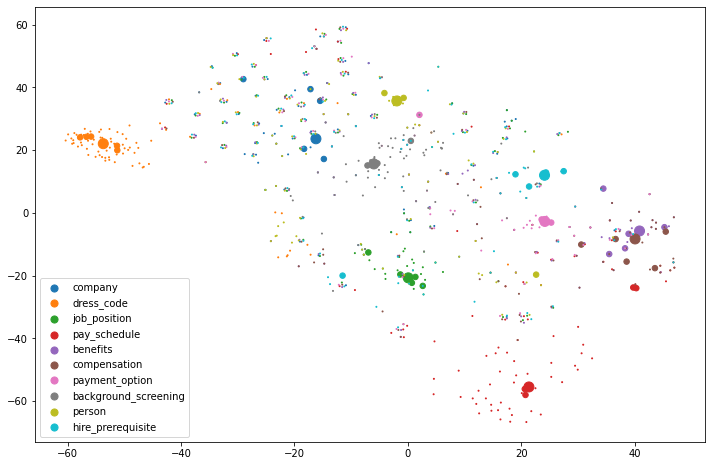

In [147]:
_tsne_x, _tsne_y = list(zip(*_tsne_emb_list))

fig = plt.figure(figsize=(12, 8))
ax = fig.gca()

# _scatter = ax.scatter(_tsne_x, _tsne_y, s=_size_list, c=_color_id_list)

cmap = plt.get_cmap(name='viridis')

for c_id, _record in enumerate(vis_records[:10]):
    _data_ids = [i for i, c in enumerate(_color_id_list) if c == c_id]
    _x = [_tsne_x[i] for i in _data_ids]
    _y = [_tsne_y[i] for i in _data_ids]
    _s = [_size_list[i] for i in _data_ids]
#     _c = [c_id for i in _data_ids]
#     _c = matplotlib.colors.rgb2hex(cmap(1.0 * c_id / len(vis_records)))
    ax.scatter(_x, _y, s=_s, label=_record[0][0])

ax.legend()
fig.show()

In [ ]:
# legend1 = ax.legend(*_scatter.legend_elements(), title="Classes")
# # ax.add_artist(legend1)
# fig.show()

In [ ]:
# matplotlib.colors.rgb2hex(cmap(0.9))

## Entity expansion evaluation
Now using benchmark entities, mean reciprocal rank

In [129]:
seed_aligned_concepts_path = os.path.join(base_dir, f'data/indeed-benchmark/seed_aligned_concepts.csv')
seed_aligned_relations_path = os.path.join(base_dir, f'data/indeed-benchmark/seed_aligned_relations.csv')
benchmark_path = os.path.join(base_dir, f'data/indeed-benchmark/benchmark_evidence_clean.csv')
concept_knn_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/concept_knn_1000.csv')

seed_aligned_concepts = load_seed_aligned_concepts(seed_aligned_concepts_path)
seed_aligned_relations = load_seed_aligned_relations(seed_aligned_relations_path)
benchmark = pd.read_csv(benchmark_path)
concept_knn = pd.read_csv(concept_knn_path)

print(seed_aligned_concepts['alignedCategoryName'].tolist())
print(seed_aligned_relations['alignedRelationName'].tolist())
print(set(concept_knn['concept'].tolist()))
print(benchmark.shape)

['company', 'dress_code', 'job_position', 'pay_schedule', 'benefits', 'compensation', 'payment_option', 'background_screening', 'person', 'hire_prerequisite', 'shifts', 'schedule', 'employee_type', 'onboarding_steps']
['has_pay_schedule', 'has_pay_schedule', 'has_dress_code', 'has_dress_code', 'has_background_screening', 'has_benefits', 'has_benefits', 'hires_person', 'has_compensation', 'has_compensation', 'has_hire_prerequisite', 'operates_on', 'hires_employee_type', 'has_onboarding_steps', 'has_shifts', 'has_shifts', 'has_job_position', 'has_hiring_policy', 'has_payment_option']
{'onboarding_steps', 'pay_schedule', 'shifts', 'schedule', 'company', 'job_position', 'hire_prerequisite', 'payment_option', 'benefits', 'background_screening', 'person', 'employee_type', 'dress_code', 'compensation'}
(706, 17)


In [62]:
def evaluate_EE(predictions_path,
                seed_concepts_path,
                seed_relations_path,
                benchmark_path):
    '''Format of prediction file: CSV, with column "concept" and "neighbor"(entity) '''
    preds_df = pd.read_csv(predictions_path)
    
    all_benchmark_instances, _ = load_benchmark(benchmark_path, seed_concepts_path, seed_relations_path)
    seed_aligned_concepts = load_seed_aligned_concepts(seed_concepts_path)
    
    mrr_dict = dict()
    for i, d in seed_aligned_concepts.iterrows():
        a_concept = d["alignedCategoryName"]
        u_concept = d["unalignedCategoryName"]
        seed_instances = d["seedInstances"]

#         concept_knn_instances = concept_knn[concept_knn["concept"] == a_concept]["neighbor"].to_list()
        pred_instances = preds_df[preds_df["concept"] == a_concept]["neighbor"].to_list()

#         _b_head_instances = benchmark[benchmark["n_head_category"] == a_concept]["n_head"].to_list()
#         _b_tail_instances = benchmark[benchmark["n_tail_category"] == a_concept]["n_tail"].to_list()
#         benchmark_instances = list(set(_b_head_instances + _b_tail_instances))
        benchmark_instances = all_benchmark_instances[a_concept]

        print(f'Concept: {a_concept} / {u_concept}')
        print(f'seeds: {seed_instances}')
        b_inst_ranks = dict()
        recip_ranks = []
        for _inst in benchmark_instances:
            if _inst in seed_instances:
                b_inst_ranks[_inst] = -1
            elif _inst in pred_instances:
                _rank = pred_instances.index(_inst) + 1
                b_inst_ranks[_inst] = _rank
                recip_ranks.append(1.0 / _rank)
            else:
                b_inst_ranks[_inst] = float('nan')
                recip_ranks.append(0.0)
                
        mrr = np.mean(recip_ranks) if len(recip_ranks) > 0 else 0.0
        mrr_dict[a_concept] = mrr
        print(json.dumps(b_inst_ranks, indent=4))
        print('MRR:', mrr)
        print()

    print('--- Summary ---')
    print(json.dumps(mrr_dict, indent=2))

In [ ]:
seed_aligned_concepts_path = os.path.join(base_dir, f'data/indeed-benchmark/seed_aligned_concepts.csv')
seed_aligned_relations_path = os.path.join(base_dir, f'data/indeed-benchmark/seed_aligned_relations_nodup.csv')
benchmark_path = os.path.join(base_dir, f'data/indeed-benchmark/benchmark_evidence_clean.csv')
concept_knn_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/concept_knn_1000.csv')

evaluate_EE(predictions_path=concept_knn_path,
            seed_concepts_path=seed_aligned_concepts_path,
            seed_relations_path=seed_aligned_relations_path,
            benchmark_path=benchmark_path)

In [264]:
# Use script
!python eval_entities.py \
-b $base_dir/data/indeed-benchmark \
-pred $base_dir/data/$data_ac/intermediate/concept_corr_100.csv

Concept: company / company
seeds: ['walmart', 'amazon', 'subway', 'microsoft', 'target']
{
    "frito": NaN,
    "verizon": NaN,
    "olive garden": NaN,
    "lowe's": NaN,
    "family dollar": NaN,
    "wells fargo": NaN,
    "panera": NaN,
    "instacart": NaN,
    "t-mobile": NaN,
    "chipotle": NaN,
    "training": NaN,
    "barnes & noble": NaN,
    "american eagle outfitters": NaN,
    "concentrix": NaN,
    "domino's": NaN,
    "mcdonald's": NaN,
    "foot locker": NaN,
    "ihop": NaN,
    "panera bread": NaN,
    "dunkin donuts": NaN,
    "frito lay": NaN,
    "fedex ground": NaN,
    "electric": NaN,
    "marshalls": 272,
    "victoria's secret": NaN,
    "g4s": NaN,
    "chilis": NaN,
    "cvs": 426,
    "pepsi": NaN,
    "dollar general": 251,
    "sonic drive-in": NaN,
    "costco": NaN,
    "allied universal security services, systems and solutions": NaN,
    "wendys": NaN,
    "pizza hut": NaN,
    "geico": NaN,
    "spectrum": NaN,
    "chipotle mexican grill": NaN,
  

Concept: onboarding_steps / onboarding process steps
seeds: ['orientation', 'introduction', 'workstation', 'training', 'team lunch']
{
    "training classes": 179,
    "training program": 54,
    "training": -1,
    "orientation": -1
}
MRR: 0.012052555348644734

--- Summary ---
{
  "company": 0.0005168180947036233,
  "dress_code": 0.01826566099506606,
  "job_position": 0.0012077294685990338,
  "pay_schedule": 0.07473544973544974,
  "benefits": 0.010131751498160353,
  "compensation": 0.0,
  "payment_option": 0.017543859649122806,
  "background_screening": 0.015741333766030093,
  "person": 0.01126500461680517,
  "hire_prerequisite": 0.02765488954960228,
  "shifts": 0.1604516129032258,
  "schedule": 0.0,
  "employee_type": 0.0006830601092896175,
  "onboarding_steps": 0.012052555348644734
}


In [265]:
# Use script
!python eval_entities.py \
-b $base_dir/data/indeed-benchmark \
-pred $base_dir/data/$data_ac/intermediate/concept_knn_100.csv


Concept: company / company
seeds: ['walmart', 'amazon', 'subway', 'microsoft', 'target']
{
    "geico": 30,
    "goodwill industries": NaN,
    "dunkin' donuts": NaN,
    "wells fargo": 50,
    "sonic drive-in": NaN,
    "domino's": NaN,
    "pizza hut": 9,
    "frito-lay": NaN,
    "marshalls": 35,
    "fedex ground": NaN,
    "whole foods market": NaN,
    "burger king": 32,
    "target": -1,
    "tim hortons": NaN,
    "t.j. maxx": NaN,
    "cracker barrel": 20,
    "subways": NaN,
    "ulta": NaN,
    "olive garden": 12,
    "kroger": 7,
    "spectrum": 18,
    "verizon": 38,
    "united states postal service": NaN,
    "frito": NaN,
    "taco bell": 37,
    "mcdonald": NaN,
    "dick's sporting goods": NaN,
    "training": 92,
    "ups": NaN,
    "panera bread": 11,
    "lowe's": NaN,
    "walgreens": 6,
    "primark": NaN,
    "mcdonalds": 14,
    "foot locker": NaN,
    "applebee's": NaN,
    "chipotle": 34,
    "dollar tree": 17,
    "t-mobile": NaN,
    "costco wholesale": NaN

# LM probes

## LM correlation-based

### BERT

In [226]:
# corpus_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/sentences_with_company.json')

# with open(corpus_path, 'r') as f:
#     sent_dicts = [json.loads(l) for l in f]

In [227]:
lm_probe = LMProbe()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [228]:
# input_file_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/sent_segmentation.txt')
# ent_freq, dedup_context = get_masked_contexts(input_file_path)

corpus_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/sentences_with_company.json')
embed_num_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/BERTembednum+seeds.txt')

entities, dedup_context = get_masked_contexts(corpus_path, embed_num_path)

In [229]:
len(entities), len(set(entities)), len(dedup_context)

(8064, 8064, 7921)

In [230]:
all_ents_tokenized = [tuple(lm_probe.tokenizer.tokenize(e)) for e in entities]
all_ents_tokenized = list(set(all_ents_tokenized))
[sum([len(e_t) == _l for e_t in all_ents_tokenized]) for _l in (1,2,3,4,5)]

[2372, 4132, 1144, 314, 55]

In [247]:
## TODO: keep rank in output

def entity_expansion_corr(seed_concepts_path=seed_aligned_concepts_path,
                          all_contexts=dedup_context, 
                          all_ents_tokenized=all_ents_tokenized, 
                          lm_probe=lm_probe,
                          max_allowed_ngrams=3,
                          max_contexts=50,
                          top_k=100):
    if lm_probe is None:
        lm_probe = LMProbe()
        
    seed_concepts_df = load_seed_aligned_concepts(seed_concepts_path)
    
#     if contexts is None:
#         try:
#             contexts = dedup_context[entity]
#         except KeyError:
#             print(f'"{entity}" not an extracted entity!')
#             return None

    _out_records = []

    for i, (a_concept, u_concept, gnrl, seed_instances) in tqdm(seed_concepts_df.iterrows(), total=seed_concepts_df.shape[0]):
        _expand_set = set()
        _expand_records = []
        
        for _inst in seed_instances:
            print(f'{a_concept} :: {_inst}')
            try:
                contexts = all_contexts[_inst]
            except KeyError:
                print(f'"{_inst}" not an extracted entity!')
                continue
            if len(contexts) < 2:
                print(f'"{_inst}" only have {len(contexts)} context')
                continue

            _entity_pieces = lm_probe.tokenizer.tokenize(_inst)
            if len(_entity_pieces) > max_allowed_ngrams:
                print(f'{_entity_pieces} too many word pieces (max {max_allowed_ngrams})')
                continue

            entity2probs = defaultdict(list)

            for _context in contexts[:max_contexts]:
                for n_grams in range(1, max_allowed_ngrams+1):
                    _ctxt = _context.replace('[MASK]', '[MASK]' + ' [MASK]' * (n_grams-1))
                    _ctxt = '[CLS] ' + _ctxt + ' [SEP]'
                    _cands = [e_t for e_t in all_ents_tokenized if len(e_t) == n_grams]
                    _cand_scores = lm_probe.score_candidates(_ctxt, _cands)

                    for _d in _cand_scores:
                        _c = ' '.join(_d['cand']).replace(' ##', '')
                        _s = _d['score']
                        entity2probs[_c].append(_s)

        #     print('entity2probs:', len(entity2probs), len(entity2probs[entity]))
            for _e, _ss in entity2probs.items():
                assert len(_ss) == len(entity2probs[_inst]), \
                    f'entity: {_e} | {lm_probe.tokenizer.tokenize(_e)}\n\
                    len(_ss) = {len(_ss)}\n\
                    len(entity2probs["{entity}"]) = {len(entity2probs[entity])}'

            _target_ss = entity2probs[_inst]
            _target_ss = _target_ss / np.sum(_target_ss)

        #     print(_target_ss.shape, _target_ss)

            mean_l = [(_e, np.mean(_ss)) for _e, _ss in entity2probs.items()]
            mean_l.sort(key=lambda p : p[-1], reverse=True)
            kl_l = [(_e, entropy(_target_ss, _ss)) for _e, _ss in entity2probs.items()]
            kl_l.sort(key=lambda p : p[-1], reverse=False)
            pearson_l = [(_e, pearsonr(_target_ss, _ss)[0]) for _e, _ss in entity2probs.items()]
            pearson_l.sort(key=lambda p : p[-1], reverse=True)

            entity2ranks = defaultdict(list)
            entity2scores = defaultdict(dict)
            for i, (_e, _s) in enumerate(mean_l):
                entity2ranks[_e].append(i)
                entity2scores[_e]["mean"] = _s
            for i, (_e, _s) in enumerate(kl_l):
                entity2ranks[_e].append(i)
                entity2scores[_e]["kl"] = _s
            for i, (_e, _s) in enumerate(pearson_l):
                entity2ranks[_e].append(i)
                entity2scores[_e]["pearson"] = _s
            # To simile top-k set intersection, keep the highest rank of _e among each criteria
            entity_overall_ranks = [(_e, max(_ranks)) for _e, _ranks in entity2ranks.items()]
            entity_overall_ranks.sort(key=lambda p : p[-1])
            entity_overall_ranks_dict = dict(entity_overall_ranks)
#             # Now, the top-k is for the final selection, not for each criteria
            sel_entities = [_e for _e, _ in entity_overall_ranks[:top_k]]

#             ints_mean_l = [p for p in mean_l if p[0] in sel_entities]
#             ints_kl_l = [p for p in kl_l if p[0] in sel_entities]
#             ints_pearson_l = [p for p in pearson_l if p[0] in sel_entities]

#             return {
#                 "entity2probs": entity2probs,
#                 "mean_l": mean_l,
#                 "kl_l": kl_l,
#                 "pearson_l": pearson_l,
#                 "sel_entities": sel_entities,
#                 "ints_mean_l": ints_mean_l,
#                 "ints_kl_l": ints_kl_l,
#                 "ints_pearson_l": ints_pearson_l,
#             }

            for _e in sel_entities:
                if (_e in _expand_set) or (_e in seed_instances):
                    continue
                _expand_set.add(_e)
                _d = dict(entity2scores[_e])
                _d['max_rank'] = entity_overall_ranks_dict[_e]
                _expand_records.append((_e, _d))

#         for _inst in seed_instances:
#             _expand_set.discard(_inst)

        for _e, _d in _expand_records:
            _out_d = dict(_d)
            _out_d['concept'] = a_concept
            _out_d['neighbor'] = _e
            _out_records.append(_out_d)

    return _out_records

#### full run & save

In [248]:
corr_expansion_out_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/concept_corr_100.csv')

In [ ]:
entity_expansion_corr(max_contexts=5)

In [263]:
# Use scripts
!python compute_EE_corr.py \
-d $base_dir/data/$data_ac/intermediate \
-b $base_dir/data/indeed-benchmark \
-o $base_dir/data/$data_ac/intermediate/concept_corr_100.csv \
-ng 3 \
-ct 50 \
-top_k 100

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
  0%|                                                    | 0/14 [00:00<?, ?it/s]company :: walmart
company :: amazon
company :: subway
company :: microsoft
company :: target
  7%|███▏                                        | 1/14 [01:13<16:01, 73.94s/it]dress_code :: business casual
dress_code :: uniform
dress_code :: hair color
dress_code :: tattoos
dress_code :: 

#### observations

In [20]:
_entity = 'health insurance'
_results = entity_expansion_multiways(_entity)

In [216]:
len(_results['sel_entities'])

20

In [217]:
_results['sel_entities']

['insurance',
 'health insurance',
 'life insurance',
 'property insurance',
 'disability insurance',
 'health care insurance',
 'personal life',
 'car insurance',
 'offer health insurance',
 'vision insurance',
 'medical insurance',
 'dental insurance',
 'social life',
 'healthcare',
 'vehicle insurance',
 'health care',
 'social services',
 'financial services',
 'personal property',
 'insurance company']

In [218]:
_entity = 'paid vacation'
_results = entity_expansion_multiways(_entity)

In [219]:
len(_results['sel_entities']), _results['sel_entities']

(20,
 ['paid vacation',
  'free food',
  'extra hours',
  'personal life',
  'additional training',
  'pay rent',
  'extra cash',
  'employment',
  'extra money',
  'regular employee',
  'actual training',
  'free market',
  'home office',
  'paid weekly',
  'lunch break',
  'employment contract',
  'paid vacations',
  'starting pay',
  'training class',
  'cash office'])

In [220]:
_results['ints_mean_l']

[('paid vacation', 0.0044874584203954135),
 ('free food', 0.0030260901631086125),
 ('employment', 0.0026738146242238693),
 ('additional training', 0.002321403750532552),
 ('pay rent', 0.0016830003481619713),
 ('extra money', 0.0012204012291167322),
 ('extra hours', 0.0012082061174470255),
 ('paid vacations', 0.00120581120557009),
 ('personal life', 0.001053836581509607),
 ('extra cash', 0.0009903957854880568),
 ('free market', 0.0007903035967739137),
 ('employment contract', 0.0007457378170482977),
 ('regular employee', 0.0007120051084749063),
 ('actual training', 0.0006806927853699615),
 ('home office', 0.0006772145559134888),
 ('paid weekly', 0.0006510896439229592),
 ('lunch break', 0.0006262294878335945),
 ('starting pay', 0.0005959591850205348),
 ('training class', 0.0005751933163302262),
 ('cash office', 0.0005385432788353982)]

In [222]:
_results['ints_kl_l']

[('paid vacation', 0.0),
 ('paid weekly', 0.3553680094673442),
 ('regular employee', 0.5651236328627899),
 ('starting pay', 0.6403464447016876),
 ('home office', 0.702709761379911),
 ('extra hours', 0.7882322979791239),
 ('cash office', 0.8216374067668454),
 ('additional training', 0.8231515801756707),
 ('free food', 0.8235410993620799),
 ('extra cash', 0.8406818348940776),
 ('lunch break', 0.8554870473017729),
 ('extra money', 0.8671142026312799),
 ('actual training', 0.8861361628894645),
 ('free market', 0.8934745945926472),
 ('personal life', 0.905080634158609),
 ('pay rent', 0.9191154476332102),
 ('training class', 0.9618010548607787),
 ('employment', 1.0064966364964134),
 ('employment contract', 1.0666759660272174),
 ('paid vacations', 1.07702367185203)]

In [221]:
_results['ints_pearson_l']

[('paid vacation', 1.0),
 ('paid weekly', 0.6898791401226259),
 ('personal life', 0.6470476793642793),
 ('home office', 0.6137368598658344),
 ('employment', 0.5939260343586834),
 ('regular employee', 0.5934659341843702),
 ('free food', 0.5814593375358278),
 ('actual training', 0.5171393046252428),
 ('extra hours', 0.48931553441132725),
 ('cash office', 0.4649905535739707),
 ('training class', 0.45922641771917155),
 ('additional training', 0.453205530878079),
 ('starting pay', 0.4452037644119071),
 ('employment contract', 0.439553353761904),
 ('pay rent', 0.4366836227238857),
 ('lunch break', 0.43380180618257874),
 ('extra cash', 0.4258937516890552),
 ('extra money', 0.4070871841193142),
 ('paid vacations', 0.4019298655642553),
 ('free market', 0.40088368759801624)]

In [223]:
entity2probs = _results['entity2probs']
_ser1 = entity2probs['paid vacation']
_ser2 = entity2probs['training class']
_ser3 = entity2probs['cash office']

_ser1 = (_ser1 - min(_ser1)) / (max(_ser1) - min(_ser1))
_ser2 = (_ser2 - min(_ser2)) / (max(_ser2) - min(_ser2))
_ser3 = (_ser3 - min(_ser3)) / (max(_ser3) - min(_ser3))

list(zip(dedup_context['paid vacation'], _ser1, _ser2, _ser3))

[('Both medical and dental insurance is provided as well as [MASK]',
  6.578818802360679e-06,
  0.00015682175491799882,
  0.0018069056141044838),
 ('No the [MASK] tome will be put on your final pay check',
  9.477934070825445e-05,
  0.00179112735515401,
  0.01783658171282455),
 ("A new policy came out apparently saying that you do n't get a week of [MASK] in the first year , if you start after June 1st .",
  0.4888658700418125,
  1.0,
  0.08162912113546698),
 ('It is very true that dollar tree do nt pay out your owed [MASK] when you are no longer working for them .',
  0.0022030048390930365,
  0.0038430425562789427,
  0.6893102387382053),
 ('But they offer no [MASK] and no sick leave .',
  0.026742685344147428,
  0.05176876375876567,
  0.25499081609946683),
 ('They give [MASK] and sick time , health and dental insurance , 401k , life insurance',
  0.9423141194865929,
  0.027970293703116284,
  0.8023113287226477),
 ('only assistant managers and general managers received [MASK] pay and s

In [ ]:
_entity = 'flexible schedule'
_results = entity_expansion_multiways(_entity)

In [ ]:
len(_results['mean_set'] & _results['kl_set'] & _results['pearson_set']), \
_results['mean_set'] & _results['kl_set'] & _results['pearson_set']

In [ ]:
_results['ints_mean_l']

In [ ]:
_results['ints_pearson_l']

In [ ]:
entity2probs = _results['entity2probs']
_ser1 = entity2probs['flexible schedule']
_ser2 = entity2probs['model']
_ser3 = entity2probs['low level']

_ser1 = (_ser1 - min(_ser1)) / (max(_ser1) - min(_ser1))
_ser2 = (_ser2 - min(_ser2)) / (max(_ser2) - min(_ser2))
_ser3 = (_ser3 - min(_ser3)) / (max(_ser3) - min(_ser3))

list(zip(dedup_context['flexible schedule'], _ser1, _ser2, _ser3))

In [ ]:
lm_probe.fill_multi_mask("[CLS] They have a very [MASK] [MASK] for most departments and if your schedule does n't fit , you 'll more than likely just be moved . [SEP]", topk=20)

In [ ]:
_entity = 'black jeans'
mean_set, kl_set, pearson_set = entity_expansion_multiways(_entity)

In [ ]:
len(mean_set & kl_set & pearson_set), mean_set & kl_set & pearson_set

In [ ]:
_entity = 'walmart'
mean_set, kl_set, pearson_set = entity_expansion_multiways(_entity)

In [ ]:
len(mean_set & kl_set & pearson_set), mean_set & kl_set & pearson_set

### GPT2

In [10]:
lm_probe_gpt2 = LMProbe_GPT2()

In [13]:
def entity_expansion_multiways_GPT2(entity, 
                                    contexts=None, 
                                    entities=entities, 
                                    lm_probe=lm_probe_gpt2, 
                                    top_k=20):
    if lm_probe is None:
        lm_probe = LMProbe_GPT2()
    if contexts is None:
        contexts = dedup_context[entity]
    
    # test: speed up x100
    entities = entities[::100]
    
    entity2probs = defaultdict(list)

    for _context in tqdm(contexts[:50]):
        _cand_scores = lm_probe.score_candidates(_context, entities)

        for _d in _cand_scores:
            _c = _d['cand']
            _s = _d['score']
            entity2probs[_c].append(_s)
    
#     print('entity2probs:', len(entity2probs), len(entity2probs[entity]))
    for _e, _ss in entity2probs.items():
        assert len(_ss) == len(entity2probs[entity]), \
            f'entity: {_e} | {lm_probe.tokenizer.tokenize(_e)}; len(_ss): {len(_ss)}'
    
    _target_ss = entity2probs[entity]
    _target_ss = _target_ss / np.sum(_target_ss)
    
    mean_l = [(_e, np.mean(_ss)) for _e, _ss in entity2probs.items()]
    mean_l.sort(key=lambda p : p[-1], reverse=True)
    kl_l = [(_e, entropy(_target_ss, _ss)) for _e, _ss in entity2probs.items()]
    kl_l.sort(key=lambda p : p[-1], reverse=False)
    pearson_l = [(_e, pearsonr(_target_ss, _ss)[0]) for _e, _ss in entity2probs.items()]
    pearson_l.sort(key=lambda p : p[-1], reverse=True)
    
    entity2ranks = defaultdict(list)
    for i, (_e, _s) in enumerate(mean_l):
        entity2ranks[_e].append(i)
    for i, (_e, _s) in enumerate(kl_l):
        entity2ranks[_e].append(i)
    for i, (_e, _s) in enumerate(pearson_l):
        entity2ranks[_e].append(i)
    # To simile top-k set intersection, keep the highest rank of _e among each criteria
    entity_overall_ranks = [(_e, max(_ranks)) for _e, _ranks in entity2ranks.items()]
    entity_overall_ranks.sort(key=lambda p : p[-1])
    # Now, the top-k is for the final selection, not for each criteria
    sel_entities = [_e for _e, _ in entity_overall_ranks[:top_k]]
    
#     mean_set = set([_e for _e, _s in mean_l[:top_k]])
#     kl_set = set([_e for _e, _s in kl_l[:top_k]])
#     pearson_set = set([_e for _e, _s in pearson_l[:top_k]])
    
#     sel_entities = mean_set & kl_set & pearson_set
    ints_mean_l = [p for p in mean_l if p[0] in sel_entities]
    ints_kl_l = [p for p in kl_l if p[0] in sel_entities]
    ints_pearson_l = [p for p in pearson_l if p[0] in sel_entities]
    
    return {
        "entity2probs": entity2probs,
        "mean_l": mean_l,
        "kl_l": kl_l,
        "pearson_l": pearson_l,
#         "mean_set": mean_set,
#         "kl_set": kl_set,
#         "pearson_set": pearson_set,
        "sel_entities": sel_entities,
        "ints_mean_l": ints_mean_l,
        "ints_kl_l": ints_kl_l,
        "ints_pearson_l": ints_pearson_l,
    }
    

In [ ]:
_entity = 'health insurance'
_results = entity_expansion_multiways_GPT2(_entity)

## BERT greedy-filling

In [344]:
class LMProbe_PMI_greedy(object):
    def __init__(self, model_name='bert-base-uncased', use_gpu=False):
        self.device = torch.device('cuda' if torch.cuda.is_available() and use_gpu else 'cpu')
        self.tokenizer = BertTokenizer.from_pretrained(model_name)
        self.model = BertForMaskedLM.from_pretrained(model_name)
        self.model.to(self.device)
        self.model.eval()

        self.mask_token = self.tokenizer.mask_token

    def fill_multi_mask(self, input_txt, topk=3):
        raise NotImplementedError
    
    def score_tail(self, input_txt, tail, head=None, head_len=None, head_first=True):
        # input_txt: str, with [HEAD] for head and [TAIL] for tail 
        # tail: str, the tail entity 
        # head: str, the head entity 
        # head_len: int, the length of head entity
        # Should only give head or head_len 
        # head_first: bool, whether the first [MASK] is the head 
        
        assert (head is None) + (head_len is None) == 1, \
            f"head = {head}, head_len = {head_len}"
        assert input_txt.count("[HEAD]") == input_txt.count("[TAIL]") == 1, \
            f"Input string must have [HEAD] and [TAIL], got {input_txt}"
        
        
        tail_toks = self.tokenizer.tokenize(tail)
        tail_len = len(tail_toks)
        input_txt = input_txt.replace('[TAIL]', '[MASK]' + ' [MASK]' * (tail_len-1))
        
        if head is not None:
            head_toks = self.tokenizer.tokenize(head)
            head_len = len(head_toks)
            print(head_toks, head_len)
            input_txt = input_txt.replace('[HEAD]', head)
        else:
            input_txt = input_txt.replace('[HEAD]', '[MASK]' + ' [MASK]' * (head_len-1))
        
        tokenized_txt = self.tokenizer.tokenize(input_txt)
        tokenized_txt = ['[CLS]'] + tokenized_txt + ['[SEP]']

        indexed_tokens = self.tokenizer.convert_tokens_to_ids(tokenized_txt)
        tokens_tensor = torch.tensor([indexed_tokens])
        mask_indices = [i for i, x in enumerate(tokenized_txt) if x == "[MASK]"]
        if head is not None:
            # head is not [MASK] 
            tail_indices = mask_indices
        elif head_first:
            # head is [MASK] and first 
            tail_indices = mask_indices[head_len:]
        else:
            # head is [MASK] and second 
            tail_indices = mask_indices[:tail_len]
        print(tokenized_txt, tail_indices)
        
        segment_idx = tokens_tensor * 0
        tokens_tensor = tokens_tensor.to(self.device)
        segments_tensors = segment_idx.to(self.device)

        with torch.no_grad():
            outputs = self.model(tokens_tensor, token_type_ids=segments_tensors)
            predictions = outputs[0]

        probs = torch.softmax(predictions, dim=-1)[0]
        probs = probs.detach().cpu().numpy()
        
        _scores = []
        tail_tok_ids = self.tokenizer.convert_tokens_to_ids(tail_toks)
        for i, token_id in zip(tail_indices, tail_tok_ids):
            _scores.append(probs[i, token_id].item())
        score = gmean(_scores)

        return score

In [345]:
lm_probe_greedy = LMProbe_PMI_greedy()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [346]:
_sent = '[HEAD] hires [TAIL]'

lm_probe_greedy.score_tail(_sent, tail='software engineer', head='microsoft', head_first=True)

['microsoft'] 1
['[CLS]', 'microsoft', 'hires', '[MASK]', '[MASK]', '[SEP]'] [3, 4]


5.249095345026383e-07

In [347]:
lm_probe_greedy.score_tail(_sent, tail='software engineer', head_len=1, head_first=True)

['[CLS]', '[MASK]', 'hires', '[MASK]', '[MASK]', '[SEP]'] [3, 4]


2.0638130627670454e-07

# Relation Extraction Baselines
Currently only for single relation. TODO: include all relations

## Null baseline - Cartesian product

In [200]:
def full_Cartesian_RE(seed_concepts_path,
                      seed_relations_path,
                      concept_knn_path,
                      relation,
                      topk=None,
                      dest=None,
                      **kwargs):
    
    seed_concepts_df = load_seed_aligned_concepts(seed_concepts_path)
    seed_relations_df = pd.read_csv(seed_relations_path)
    relation_row = seed_relations_df[seed_relations_df['alignedRelationName'] == relation].iloc[0]
    concept_knn_results = pd.read_csv(concept_knn_path)
    
    head_type = relation_row['domain']
    tail_type = relation_row['range']
    print(head_type, '\t', tail_type)
    seed_heads = seed_concepts_df[seed_concepts_df['alignedCategoryName'] == head_type]['seedInstances'].item()
#     seed_heads = eval(list(seed_heads)[0])
    seed_tails = seed_concepts_df[seed_concepts_df['alignedCategoryName'] == tail_type]['seedInstances'].item()
#     seed_tails = eval(list(seed_tails)[0])
    print('seed_heads:', seed_heads)
    print('seed_tails:', seed_tails)

    # Candidate heads / tails from concept knn 
    cand_heads_df = concept_knn_results[concept_knn_results['concept'] == head_type]
    cand_tails_df = concept_knn_results[concept_knn_results['concept'] == tail_type]
    cand_heads = [(_h, 1.0) for _h in seed_heads] + \
        list(zip(cand_heads_df['neighbor'].tolist(), cand_heads_df['sim'].tolist()))
    cand_tails = [(_t, 1.0) for _t in seed_tails] + \
        list(zip(cand_tails_df['neighbor'].tolist(), cand_tails_df['sim'].tolist()))

    if topk is not None:
        cand_heads = cand_heads[:topk]
        cand_tails = cand_tails[:topk]
        
    print('cand_heads:', list(zip(*cand_heads))[0])
    print('cand_tails:', list(zip(*cand_tails))[0])
    
    out_rels = []
    for _h, _hs in cand_heads:
        for _t, _ts in cand_tails:
            out_rels.append({
                'head': _h, 'relation': relation, 'tail': _t,
                'overall_score': _hs * _ts
            })
    out_rels.sort(key=lambda d : d['overall_score'], reverse=True)
    
    out_rels_df = pd.DataFrame(out_rels)
    if dest is not None:
        out_rels_df.to_csv(dest, index=False)
    return out_rels_df

In [226]:
seed_concepts_path = os.path.join(base_dir, f'data/indeed-benchmark/seed_concepts.csv')
seed_relations_path = os.path.join(base_dir, f'data/indeed-benchmark/seed_relations.csv')
seed_aligned_concepts_path = os.path.join(base_dir, f'data/indeed-benchmark/seed_aligned_concepts.csv')
seed_aligned_relations_path = os.path.join(base_dir, f'data/indeed-benchmark/seed_aligned_relations_nodup.csv')
# knn_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/knn_{cluster_size}.csv')
concept_knn_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/concept_knn_1000.csv')

relation = 'has_benefits'
cartesian_re_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/rel_cartesian-{relation}.csv')

In [227]:
full_Cartesian_RE(seed_concepts_path=seed_aligned_concepts_path,
                  seed_relations_path=seed_aligned_relations_path,
                  concept_knn_path=concept_knn_path,
                  relation=relation,
                  topk=60,
                  dest=cartesian_re_path)
print('done.')

company 	 benefits
seed_heads: ['walmart', 'amazon', 'subway', 'microsoft', 'target']
seed_tails: ['health insurance', 'flexible schedule', '401k', 'paid vacation', 'sick leave', 'vision insurance']
cand_heads: ('walmart', 'amazon', 'subway', 'microsoft', 'target', 'wal mart', 'costco', 'publix', 'walgreens', 'kroger', 'home depot', "sam 's club", 'dollar general', 'family dollar', 'jcpenney', 'pizza hut', 'starbucks', 'apple', 'kfc', 'dollar tree', 'panera bread', 'safeway', 'hobby lobby', 'cracker barrel', 'spectrum', 'menards', 'chick fil a', 'old navy', 'mcdonalds', 'taco bell', 'marshalls', 'burlington', 'olive garden', 'cvs', 'pepsico', 'sitel', 'burger king', 'petsmart', 'jcp', 'pepsi', "macy 's", 'geico', 'whole foods', 'ihop', 'fedex', 'best buy', 'frito lay', 'dunkin donuts', 'chipotle', 'tj maxx', 'verizon', 't mobile', 'g4s', 'usps', 'jc penney', 'at&t', 'planet fitness', 'little caesars', 'company', 'mcdonald')
cand_tails: ('health insurance', 'flexible schedule', '401k', 

In [64]:
# Use script 
!python relation_extraction_cartesian.py \
-d $base_dir/data/$data_ac/intermediate \
-b $base_dir/data/indeed-benchmark \
-o $base_dir/data/$data_ac/intermediate/rel_extraction-has_benefits-RE=Ct.csv \
-r has_benefits \
-cknn $base_dir/data/$data_ac/intermediate/concept_knn_1000.csv \
-topk 60

company 	 benefits
seed_heads: ['walmart', 'amazon', 'subway', 'microsoft', 'target']
seed_tails: ['health insurance', 'flexible schedule', '401k', 'paid vacation', 'sick leave', 'vision insurance']
cand_heads: ('walmart', 'amazon', 'subway', 'microsoft', 'target', 'wal mart', 'costco', 'publix', 'walgreens', 'kroger', 'home depot', "sam 's club", 'dollar general', 'family dollar', 'jcpenney', 'pizza hut', 'starbucks', 'apple', 'kfc', 'dollar tree', 'panera bread', 'safeway', 'hobby lobby', 'cracker barrel', 'spectrum', 'menards', 'chick fil a', 'old navy', 'mcdonalds', 'taco bell', 'marshalls', 'burlington', 'olive garden', 'cvs', 'pepsico', 'sitel', 'burger king', 'petsmart', 'jcp', 'pepsi', "macy 's", 'geico', 'whole foods', 'ihop', 'fedex', 'best buy', 'frito lay', 'dunkin donuts', 'chipotle', 'tj maxx', 'verizon', 't mobile', 'g4s', 'usps', 'jc penney', 'at&t', 'planet fitness', 'little caesars', 'company', 'mcdonald')
cand_tails: ('health insurance', 'flexible schedule', '401k', 

## Relation Extraction - GPT2 scores (analysis)

In [292]:
# observation 

gpt2_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
gpt2_model = GPT2LMHeadModel.from_pretrained('gpt2', return_dict=True)

In [290]:
def gpt2_score(sentence):
    tokenized_input = gpt2_tokenizer(sentence, return_tensors="pt")
    with torch.no_grad():
        model_outputs = gpt2_model(**tokenized_input, labels=tokenized_input["input_ids"])
    score = model_outputs.loss.item()
    return score

In [351]:
_sent_template = '{0} offers {1}'
_heads = ['company', 'walmart', 'google', 'california']
_tails = ['benefits', '401k plan', 'paid vacation', 'family']

_print_msg = f"{'(NLL) ' + _sent_template.format('X', 'Y'):24s}"
_print_msg += '\t' + '\t'.join([f"{_t:8s}" for _t in _tails]) + '\n'
for _h in _heads:
    _print_msg += f"{_h:24s}"
    for _t in _tails:
        _sent = _sent_template.format(_h, _t)
        _score = gpt2_score(_sent)
#         print(f"(NLL = {_score:.6f}) {_sent}")
        _print_msg += f"\t{_score:.6f}"
    _print_msg += "\n"

print(_print_msg)

(NLL) X offers Y        	benefits	401k plan	paid vacation	family  
company                 	8.153534	6.109497	6.707372	8.615242
walmart                 	9.049321	6.962499	8.100282	8.999038
google                  	8.491952	6.307848	7.430027	9.093484
california              	6.713108	5.849362	6.076878	6.828558



In [350]:
_sent_template = '{0} allows {1}'
_heads = ['company', 'walmart', 'google', 'california']
_tails = ['dress code', 'jeans', 'tattoos', 'drugs']

_print_msg = f"{'(NLL) ' + _sent_template.format('X', 'Y'):24s}"
_print_msg += '\t' + '\t'.join([f"{_t:8s}" for _t in _tails]) + '\n'
for _h in _heads:
    _print_msg += f"{_h:24s}"
    for _t in _tails:
        _sent = _sent_template.format(_h, _t)
        _score = gpt2_score(_sent)
#         print(f"(NLL = {_score:.6f}) {_sent}")
        _print_msg += f"\t{_score:.6f}"
    _print_msg += "\n"

print(_print_msg)

(NLL) X allows Y        	dress code	jeans   	tattoos 	drugs   
company                 	7.646885	11.025874	10.445228	9.259410
walmart                 	8.517221	10.956227	10.929914	10.295705
google                  	8.461215	12.038675	12.965143	10.222376
california              	6.353935	7.937030	7.359611	6.910169



In [352]:
_sent_template = '{0} pays {1}'
_heads = ['company', 'walmart', 'google', 'california']
_tails = ['schedule', 'weekly', 'every friday', 'minimum wage']

_print_msg = f"{'(NLL) ' + _sent_template.format('X', 'Y'):24s}"
_print_msg += '\t' + '\t'.join([f"{_t:8s}" for _t in _tails]) + '\n'
for _h in _heads:
    _print_msg += f"{_h:24s}"
    for _t in _tails:
        _sent = _sent_template.format(_h, _t)
        _score = gpt2_score(_sent)
#         print(f"(NLL = {_score:.6f}) {_sent}")
        _print_msg += f"\t{_score:.6f}"
    _print_msg += "\n"

print(_print_msg)

(NLL) X pays Y          	schedule	weekly  	every friday	minimum wage
company                 	11.049671	9.899395	7.250698	6.185252
walmart                 	11.554404	10.105996	7.789978	7.334626
google                  	11.968147	10.422943	7.292716	7.170493
california              	8.314291	7.803281	6.406629	5.754911



## Relation Extraction - scores weighted average

In [ ]:
lm_probe = LMProbe()

In [ ]:
def get_direct_probing_candidates(templates,
                                  lm_probe=None,
                                  head_entity=None,
                                  tail_entity=None,
                                  context=None,
                                  topk=10):
    '''
    Direct probing: let BERT propose possible entities  
    :param templates: List[str]: each have 2 slots, {0} for head, {1} for tail 
    :return: Dict[str, float]: proposed entities and scores 
    '''
    
    # ensure given one and propose one 
    assert (head_entity is None) != (tail_entity is None), f'{head_entity} {tail_entity}'

    if lm_probe is None:
        lm_probe = LMProbe()
    
    names_scores = {}
    for template in templates:
        if head_entity is not None:
            # head -> tail 
            _unigram_template = template.format(head_entity, '[MASK]')
            _bigram_template = template.format(head_entity, '[MASK] [MASK]')
        else:
            # tail -> head 
            _unigram_template = template.format('[MASK]', tail_entity)
            _bigram_template = template.format('[MASK] [MASK]', tail_entity)
        
        for _template in [_unigram_template, _bigram_template]:
            if context:
                query = '[CLS] ' + _template + '[SEP]' + context + '[SEP]'
            else:
                query = '[CLS] ' + _template + '[SEP]'
            preds = lm_probe.fill_multi_mask(query, topk=topk)
            for pred in preds:
                name = ' '.join([p['token_str'] for p in pred])
                name = name.replace(' ##', '')
                score = np.prod([p['prob'] for p in pred])
                scores = names_scores.get(name, [])
                scores.append(score)
                names_scores[name] = scores
                
    names_avg_scores = {k: float(sum(v))/ len(v) for k,v in names_scores.items()}
    names_avg_scores = {k: v for k, v in sorted(names_avg_scores.items(), reverse=True, key=lambda item: item[1])[:topk]}
    return names_avg_scores

In [52]:
def direct_probing_RE_v4(seed_concepts_path,
                         seed_relations_path,
                         emb_path,
                         concept_knn_path,
                         templates_path,
                         relation,
                         lm_probe=None,
                         embedding_dim=768,
                         scores_agg_func=None,
                         topk=10,
                         dest=None,
                         **kwargs):
    '''
    For each head / tail, rank candidate tails / heads by overall scores. 
    (v4: Not limited to base -> new; can be new -> new; however, only head->tail, no tail->head)
    Current (default) overall score: 0.1 * ht_sim + 10 * concept_sim + 0.1 * log(lm_prob)
    '''
    
    seed_concepts_df = load_seed_aligned_concepts(seed_concepts_path)
    seed_relations_df = pd.read_csv(seed_relations_path)
    relation_row = seed_relations_df[seed_relations_df['alignedRelationName'] == relation].iloc[0]
    entity_embeddings = load_embeddings(emb_path, embedding_dim)
    entity_emb_dict = dict(zip(entity_embeddings['entity'].tolist(),
                               entity_embeddings['embedding'].tolist()))
    concept_knn_results = pd.read_csv(concept_knn_path)
    
    with open(templates_path, 'r') as f:
        all_templates = json.load(f)
    templates = all_templates[relation]
    templates = templates['positive'] + templates['negative']

    if lm_probe is None:
        lm_probe = LMProbe()
    if scores_agg_func is None:
        scores_agg_func = lambda ht_sim, h_sim, t_sim, lm_prob : ht_sim + h_sim + t_sim + np.log10(lm_prob)
    
    head_type = relation_row['domain']
    tail_type = relation_row['range']
#     head_type = "company"
#     tail_type = "dress_code"
    print(head_type, '\t', tail_type)
    seed_heads = seed_concepts_df[seed_concepts_df['alignedCategoryName'] == head_type]['seedInstances'].item()
#     seed_heads = eval(list(seed_heads)[0])
    seed_tails = seed_concepts_df[seed_concepts_df['alignedCategoryName'] == tail_type]['seedInstances'].item()
#     seed_tails = eval(list(seed_tails)[0])
    print('seed_heads:', seed_heads)
    print('seed_tails:', seed_tails)

    # Candidate heads / tails from concept knn 
    cand_heads_df = concept_knn_results[concept_knn_results['concept'] == head_type]
    cand_tails_df = concept_knn_results[concept_knn_results['concept'] == tail_type]
    cand_heads_dict = dict(zip(cand_heads_df['neighbor'].tolist(), cand_heads_df['sim'].tolist()))
    cand_tails_dict = dict(zip(cand_tails_df['neighbor'].tolist(), cand_tails_df['sim'].tolist()))
    for h in seed_heads:
        assert h not in cand_heads_dict
        cand_heads_dict[h] = 1.0
    for t in seed_tails:
        assert t not in cand_tails_dict
        cand_tails_dict[t] = 1.0
        
    
    all_extraction_results = []
    
    for c_head in tqdm(cand_heads_dict.keys(), total=len(cand_heads_dict)):
        c_head_tokenized = lm_probe.tokenizer.tokenize(c_head)
        if len(c_head_tokenized) > 2:
            continue

        extraction_results = []

        ## For each tail, extract concept sim, head sim, lm score, combine and report
        
        cand_bins = {1: [], 2: []} ## TODO: allow higher grams; switch to GPT-2 for fair probs 
        for c_tail in cand_tails_dict.keys():
            if c_tail == c_head:
                continue
            c_tail_tokenized = lm_probe.tokenizer.tokenize(c_tail)
            if len(c_tail_tokenized) in [1, 2]:
                cand_bins[len(c_tail_tokenized)].append(c_tail_tokenized)
        
        cand_scores_per_template = []
        for template in templates:
            _unigram_template = '[CLS] ' + template.format(c_head, '[MASK]') + '[SEP]'
            _bigram_template = '[CLS] ' + template.format(c_head, '[MASK] [MASK]') + '[SEP]'

            _cand_scores_1 = lm_probe.score_candidates(_unigram_template, cand_bins[1])
            _cand_scores_2 = lm_probe.score_candidates(_bigram_template, cand_bins[2])
            _cand_scores = sorted(_cand_scores_1 + _cand_scores_2, key=lambda d : d["cand"])
            # List[Dict["cand", "score"]]
            cand_scores_per_template.append(_cand_scores)
    
        cand_scores = []  # List[Dict["cand", "score"]], for each "cand" the average score 
        for _cand_score_lst in zip(*cand_scores_per_template):
            # _cand_score_lst: List[Dict["cand", "score"]], for the same "cand" and different template 
            _cand = _cand_score_lst[0]["cand"]
            assert all(d["cand"] == _cand for d in _cand_score_lst), _cand_score_lst
            _score = np.mean([d["score"] for d in _cand_score_lst])
            cand_scores.append({"cand": _cand, "score": _score})
#         cand_scores.sort(key = lambda d : d["score"], reverse=True)

        for d in cand_scores:
            e_tail = ' '.join(d["cand"]).replace(' ##', '')
            if e_tail not in cand_tails_dict:
                continue

            lm_score = d["score"]
            try:
                ht_sim_score = 1 - cosine(entity_emb_dict[c_head], entity_emb_dict[e_tail])
            except KeyError:
                print(f'** embedding of {c_head}: {(c_head in entity_emb_dict)}')
                print(f'** embedding of {e_tail}: {(e_tail in entity_emb_dict)}')
                ht_sim_score = float("nan")
            head_sim_score = cand_heads_dict[c_head]
            tail_sim_score = cand_tails_dict[e_tail]
            overall_score = scores_agg_func(ht_sim_score, head_sim_score, tail_sim_score, lm_score)

            extraction_results.append({'head': c_head, 'relation': relation, 'tail': e_tail,
                                       'ht_sim_score': ht_sim_score,
                                       'head_sim_score': head_sim_score,
                                       'tail_sim_score': tail_sim_score,
                                       'lm_score': lm_score,
                                       'overall_score': overall_score})
        
        # extraction_results.sort(key=lambda d : d['overall_score'], reverse=True)
        all_extraction_results.extend(extraction_results[:topk])

    all_extraction_results.sort(key=lambda d : d['overall_score'], reverse=True)
    all_extraction_results = all_extraction_results[:topk]
        
    results_df = pd.DataFrame(all_extraction_results)
    if dest is not None:
        results_df.to_csv(dest, index=None)
    return results_df


In [53]:
# seed_concepts_path = os.path.join(base_dir, f'data/indeed-benchmark/seed_concepts.csv')
# seed_relations_path = os.path.join(base_dir, f'data/indeed-benchmark/seed_relations.csv')
seed_aligned_concepts_path = os.path.join(base_dir, f'data/indeed-benchmark/seed_aligned_concepts.csv')
seed_aligned_relations_path = os.path.join(base_dir, f'data/indeed-benchmark/seed_aligned_relations_nodup.csv')
# knn_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/knn_{cluster_size}.csv')
concept_knn_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/concept_knn_100.csv')
bert_emb_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/BERTembed+seeds.txt')

templates_path = 'templates_manual.json'

extraction_save_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/rel_extraction.csv')
# extraction_save_path = None

extraction_results = direct_probing_RE_v4(seed_concepts_path=seed_aligned_concepts_path,
                                          seed_relations_path=seed_aligned_relations_path,
                                          emb_path=bert_emb_path,
                                          concept_knn_path=concept_knn_path,
                                          templates_path=templates_path,
                                          relation='has_benefits',
                                          lm_probe=lm_probe,
                                          topk=10,
                                          save_path=extraction_save_path)

extraction_results.head(5)

company 	 benefits
seed_heads: ['walmart', 'amazon', 'subway', 'microsoft', 'target']
seed_tails: ['health insurance', 'flexible schedule', '401k', 'paid vacation', 'sick leave', 'vision insurance']


,head,relation,tail,ht_sim_score,head_sim_score,tail_sim_score,lm_score,overall_score
0,company,has_benefits,business,0.993406,0.991990,0.972477,0.002870,0.415795
1,home depot,has_benefits,car insurance,0.959858,0.996124,0.973259,0.002527,0.331895
2,fulfillment center,has_benefits,business,0.983125,0.987292,0.972477,0.001832,0.205897
3,corporate office,has_benefits,business,0.984971,0.988309,0.972477,0.001797,0.200351
4,store level,has_benefits,cards,0.977417,0.988855,0.975875,0.001735,0.181516


In [ ]:
df = extraction_results.copy()
df[df['head'] == 'walmart'].head(50)
# df['overall_score'] = df['ht_sim_score'] * 0.1 + df['concept_sim_score'] * 10 + np.log10(df['lm_score'])
# df.sort_values(by='overall_score', ascending=False)

In [ ]:
df = extraction_results.copy()
df[df['tail'] == 'hair color'].head(50)
# df['overall_score'] = df['ht_sim_score'] * 0.1 + df['concept_sim_score'] * 10 + np.log10(df['lm_score'])
# df.sort_values(by='overall_score', ascending=False).head(50)

In [171]:
# Use script 
!python relation_extraction_avg_scores.py \
-d $base_dir/data/$data_ac/intermediate \
-b $base_dir/data/indeed-benchmark \
-o $base_dir/data/$data_ac/intermediate/rel_extraction-has_benefits-RE.csv \
-r has_benefits \
-cknn $base_dir/data/$data_ac/intermediate/concept_knn_1000.csv \
-topk 300 \
-dim 768


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
company 	 benefits
seed_heads: ['walmart', 'amazon', 'subway', 'microsoft', 'target']
seed_tails: ['health insurance', 'flexible schedule', '401k', 'paid vacation', 'sick leave', 'vision insurance']
seed_head: walmart
seed_head: amazon
seed_head: subway
seed_head: microsoft
seed_head: target
seed_tail: health insurance
seed_tail: flexible schedule
seed_tail: 401k
s

## Relation Extraction Evaluation

In [156]:
## Evaluation 

def load_benchmark(benchmark_full_path,
                   seed_concepts_path,
                   seed_relations_path):
    benchmark = pd.read_csv(benchmark_full_path)
    concepts_df = load_seed_aligned_concepts(seed_concepts_path)
    relations_df = load_seed_aligned_relations(seed_relations_path)
    
    concepts_dict = dict(zip(concepts_df['alignedCategoryName'].tolist(), concepts_df.to_dict('records')))
    relations_dict = dict(zip(relations_df['alignedRelationName'].tolist(), relations_df.to_dict('records')))
    
    # Dict[str(_type), Set[str(_e)]]
    all_concepts = defaultdict(set)
    # Dict[str(_r), Set[Tuple(_h, _r, _t)]]
    all_rel_tuples = defaultdict(set)
    
    for i, row in benchmark.iterrows():
        if row['type'] != 'fact':
            continue
        
        _r = row['relation_name']
        _h_type = row['n_head_category']
        _t_type = row['n_tail_category']
        
        if _r not in relations_dict:
            continue
        _relation_row = relations_dict[_r]
        if _relation_row['domain'] != _h_type or _relation_row['range'] != _t_type:
            continue
        
        row_n_head = str(row['n_head']).lower()
        row_n_tail = str(row['n_tail']).lower()
        
        if row_n_head == 'company':
            evidence_sents = eval(str(row['sentences']))
            head_instances = eval(str(row['Evidence']))
            assert len(evidence_sents) == len(head_instances), f'Line {i} length mismatch'

            for inst in head_instances:
                if len(inst) > 0:
                    all_concepts[_h_type].add(inst.lower())
                    all_concepts[_t_type].add(row_n_tail)
                    all_rel_tuples[_r].add(
                        (inst.lower(), _r, row_n_tail)
                    )
        else:
            # treat n_head directly as instance 
            all_concepts[_h_type].add(row_n_head)
            all_concepts[_t_type].add(row_n_tail)
            all_rel_tuples[_r].add(
                (row_n_head, _r, row_n_tail)
            )
        
    return all_concepts, all_rel_tuples


In [157]:
benchmark_path = os.path.join(base_dir, f'data/indeed-benchmark/benchmark_evidence_clean.csv')
seed_aligned_concepts_path = os.path.join(base_dir, f'data/indeed-benchmark/seed_aligned_concepts.csv')
seed_aligned_relations_path = os.path.join(base_dir, f'data/indeed-benchmark/seed_aligned_relations_nodup.csv')

benchmark_concepts, benchmark_relations = load_benchmark(benchmark_full_path=benchmark_path,
                                              seed_concepts_path=seed_aligned_concepts_path,
                                              seed_relations_path=seed_aligned_relations_path)

len(benchmark_concepts), len(benchmark_relations)

(15, 14)

In [15]:
rel_extraction_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/rel_extraction.csv')

rel_extraction = pd.read_csv(rel_extraction_path)
rel_extraction_list = rel_extraction[['head', 'tail']].to_dict('records')

In [16]:
benchmark_relations_set = set([tuple(d.values()) for d in benchmark_relations_list])
rel_extraction_set = set([tuple(d.values()) for d in rel_extraction_list])

intersection = benchmark_relations_set & rel_extraction_set

len(benchmark_relations_set), len(rel_extraction_set), len(intersection)


(107, 3597, 6)

### has_dress_code

In [206]:
!python eval_relations.py \
-b $base_dir/data/indeed-benchmark \
-pred $base_dir/data/$data_ac/intermediate/rel_cartesian-has_dress_code.csv \
-r has_dress_code

--- RE Results ---
Benchmark relations: 107
Predicted relations: 3600
Intersection: 15
P = 0.0042, R = 0.1402, F1 = 0.0081

Intersection:
('jcpenney', 'has_dress_code', 'uniform policy')
('olive garden', 'has_dress_code', 'facial hair')
('walgreens', 'has_dress_code', 'hair color')
('marshalls', 'has_dress_code', 'color hair')
('at&t', 'has_dress_code', 'uniform')
('costco', 'has_dress_code', 'hair color')
('walmart', 'has_dress_code', 'uniform')
('taco bell', 'has_dress_code', 'nose rings')
('walmart', 'has_dress_code', 'face tattoos')
('dollar general', 'has_dress_code', 'strict dress code')
('best buy', 'has_dress_code', 'uniform')
('family dollar', 'has_dress_code', 'facial hair')
('subway', 'has_dress_code', 'piercings')
('dollar tree', 'has_dress_code', 'uniform')
('dollar tree', 'has_dress_code', 'professional')



In [31]:
!python eval_relations.py \
-b $base_dir/data/indeed-benchmark \
-pred $base_dir/data/$data_ac/intermediate/rel_extraction-has_dress_code-RE=Ct+KV=0.9.csv \
-r has_dress_code

--- RE Results ---
Benchmark relations: 107
Predicted relations: 1018
Intersection: 13
P = 0.0128, R = 0.1215, F1 = 0.0231

Intersection:
('taco bell', 'has_dress_code', 'nose rings')
('olive garden', 'has_dress_code', 'facial hair')
('costco', 'has_dress_code', 'hair color')
('jcpenney', 'has_dress_code', 'uniform policy')
('dollar tree', 'has_dress_code', 'uniform')
('best buy', 'has_dress_code', 'uniform')
('marshalls', 'has_dress_code', 'color hair')
('walmart', 'has_dress_code', 'uniform')
('subway', 'has_dress_code', 'piercings')
('dollar tree', 'has_dress_code', 'professional')
('walgreens', 'has_dress_code', 'hair color')
('at&t', 'has_dress_code', 'uniform')
('family dollar', 'has_dress_code', 'facial hair')



In [204]:
!python eval_relations.py \
-b $base_dir/data/indeed-benchmark \
-pred $base_dir/data/$data_ac/intermediate/rel_extraction-has_dress_code-RE.csv \
-r has_dress_code

--- RE Results ---
Benchmark relations: 107
Predicted relations: 3593
Intersection: 8
P = 0.0022, R = 0.0748, F1 = 0.0043

Intersection:
('walmart', 'has_dress_code', 'uniform')
('costco', 'has_dress_code', 'hair color')
('dollar tree', 'has_dress_code', 'uniform')
('walmart', 'has_dress_code', 'face tattoos')
('subway', 'has_dress_code', 'piercings')
('family dollar', 'has_dress_code', 'facial hair')
('dd', 'has_dress_code', 'facial hair')
('best buy', 'has_dress_code', 'uniform')



In [205]:
!python eval_relations.py \
-b $base_dir/data/indeed-benchmark \
-pred $base_dir/data/$data_ac/intermediate/rel_extraction-has_dress_code-RE+KV_0.9.csv \
-r has_dress_code

--- RE Results ---
Benchmark relations: 107
Predicted relations: 613
Intersection: 7
P = 0.0114, R = 0.0654, F1 = 0.0194

Intersection:
('costco', 'has_dress_code', 'hair color')
('subway', 'has_dress_code', 'piercings')
('dd', 'has_dress_code', 'facial hair')
('walmart', 'has_dress_code', 'uniform')
('family dollar', 'has_dress_code', 'facial hair')
('best buy', 'has_dress_code', 'uniform')
('dollar tree', 'has_dress_code', 'uniform')



### has_benefits

In [228]:
!python eval_relations.py \
-b $base_dir/data/indeed-benchmark \
-pred $base_dir/data/$data_ac/intermediate/rel_cartesian-has_benefits.csv \
-r has_benefits

--- RE Results ---
Benchmark relations: 56
Predicted relations: 3600
Intersection: 11
P = 0.0031, R = 0.1964, F1 = 0.0060

Intersection:
('burger king', 'has_benefits', 'health')
('burger king', 'has_benefits', 'sick leave')
('walmart', 'has_benefits', '401k')
('walmart', 'has_benefits', '401k plan')
('olive garden', 'has_benefits', '401k plan')
('g4s', 'has_benefits', 'sick leave')
('walmart', 'has_benefits', 'life insurance')
('target', 'has_benefits', 'health insurance')
('walmart', 'has_benefits', 'paid vacations')
('starbucks', 'has_benefits', 'health')
('dollar general', 'has_benefits', 'health insurance')



In [32]:
!python eval_relations.py \
-b $base_dir/data/indeed-benchmark \
-pred $base_dir/data/$data_ac/intermediate/rel_extraction-has_benefits-RE=Ct+KV=0.9.csv \
-r has_benefits

--- RE Results ---
Benchmark relations: 56
Predicted relations: 1312
Intersection: 11
P = 0.0084, R = 0.1964, F1 = 0.0161

Intersection:
('starbucks', 'has_benefits', 'health')
('dollar general', 'has_benefits', 'health insurance')
('walmart', 'has_benefits', '401k plan')
('walmart', 'has_benefits', 'life insurance')
('target', 'has_benefits', 'health insurance')
('burger king', 'has_benefits', 'health')
('walmart', 'has_benefits', 'paid vacations')
('burger king', 'has_benefits', 'sick leave')
('g4s', 'has_benefits', 'sick leave')
('walmart', 'has_benefits', '401k')
('olive garden', 'has_benefits', '401k plan')



In [175]:
!python eval_relations.py \
-b $base_dir/data/indeed-benchmark \
-pred $base_dir/data/$data_ac/intermediate/rel_extraction-has_benefits-RE.csv \
-r has_benefits

--- RE Results ---
Benchmark relations: 56
Predicted relations: 3294
Intersection: 5
P = 0.0015, R = 0.0893, F1 = 0.0030

Intersection:
('dollar general', 'has_benefits', 'health insurance')
('burger king', 'has_benefits', 'sick leave')
('target', 'has_benefits', 'health insurance')
('walmart', 'has_benefits', '401k')
('walmart', 'has_benefits', 'life insurance')



In [30]:
!python eval_relations.py \
-b $base_dir/data/indeed-benchmark \
-pred $base_dir/data/$data_ac/intermediate/rel_extraction-has_benefits-RE+KV_0.9.csv \
-r has_benefits

--- RE Results ---
Benchmark relations: 56
Predicted relations: 713
Intersection: 5
P = 0.0070, R = 0.0893, F1 = 0.0130

Intersection:
('target', 'has_benefits', 'health insurance')
('walmart', 'has_benefits', '401k')
('burger king', 'has_benefits', 'sick leave')
('walmart', 'has_benefits', 'life insurance')
('dollar general', 'has_benefits', 'health insurance')



## LMProbe-Joint

In [244]:
gpt2_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
gpt2_model = GPT2LMHeadModel.from_pretrained('gpt2', return_dict=True)

In [249]:
_inputs = gpt2_tokenizer("Hello, my dog is cute", return_tensors="pt")
_inputs

{'input_ids': tensor([[15496,    11,   616,  3290,   318, 13779]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}

In [246]:
with torch.no_grad():
    _outputs = gpt2_model(**_inputs, labels=_inputs["input_ids"])

In [252]:
_outputs.loss.item()

3.9901607036590576

In [149]:
lm_probe = LMProbe()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
lm_probe.fill_multi_mask("[CLS] The payment [MASK] [MASK] is nice. [SEP]", topk=10)

In [271]:
# test
lm_probe_gpt2 = LMProbe_GPT2()

In [272]:
lm_probe_gpt2.score_candidates("They have a very [MASK] .", ["good", "plan", "good plan"])

[{'cand': 'good plan', 'score': -4.1346964836120605},
 {'cand': 'good', 'score': -4.260444641113281},
 {'cand': 'plan', 'score': -5.5930562019348145}]

In [208]:
_sent = "Hello ! I would like to have a pizzaaaa"
_inputs = lm_probe_joint.gpt2_tokenizer(_sent, return_tensors="pt")
with torch.no_grad():
    _outputs = lm_probe_joint.gpt2_model(**_inputs, labels=_inputs["input_ids"])
_outputs.loss.item() * (len(_sent.split(' ')) - 1)

40.47902297973633

In [222]:
lm_probe_joint.gpt2_tokenizer(_sent)

{'input_ids': [15496, 5145, 314, 561, 588, 284, 423, 257, 14256, 46071], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [209]:
_inputs

{'input_ids': tensor([[15496,  5145,   314,   561,   588,   284,   423,   257, 14256, 46071]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [211]:
lm_probe_joint.gpt2_tokenizer.convert_ids_to_tokens([15496,  5145,   314,   561,   588,   284,   423,   257, 14256, 46071])

['Hello', 'Ġ!', 'ĠI', 'Ġwould', 'Ġlike', 'Ġto', 'Ġhave', 'Ġa', 'Ġpizza', 'aaa']

In [223]:
# LMProbe_Joint with bert probs renormalized by gpt2 

def _bert_untokenize(pieces):
    return ' '.join(pieces).replace(' ##', '')

class LMProbe_Joint(object):
    def __init__(self,
                 bert_model_name='bert-base-uncased',
                 gpt2_model_name='gpt2',
                 max_n_grams=5,
                 use_gpu=False):
        self.device = torch.device('cuda' if torch.cuda.is_available() and use_gpu else 'cpu')
        self.bert_tokenizer = BertTokenizer.from_pretrained(bert_model_name)
        self.bert_model = BertForMaskedLM.from_pretrained(bert_model_name)
        self.bert_model.to(self.device)
        self.bert_model.eval()
        self.bert_mask_token = self.bert_tokenizer.mask_token
        
        self.gpt2_tokenizer = GPT2Tokenizer.from_pretrained(gpt2_model_name)
        self.gpt2_model = GPT2LMHeadModel.from_pretrained(gpt2_model_name, return_dict=True)
        self.gpt2_model.to(self.device)
        self.gpt2_model.eval()
        
        self.max_n_grams = max_n_grams
        
    def joint_score_candidates(self, input_txt, cands, renorm_n=10):
        # cands: List[str], list candidates (untokenzied) 
        
        if input_txt.count("[MASK]") != 1:
            raise Exception(f'Input string must have exactly one mask token, got {input_txt}')

        cand_bins = {i : [] for i in range(1, self.max_n_grams + 1)}
        for c in cands:
            c_tokenized = self.bert_tokenizer.tokenize(c)
            if len(c_tokenized) > self.max_n_grams:
                print(f'{c_tokenized}: too many wordpieces')
                continue
            cand_bins[len(c_tokenized)].append(c_tokenized)
        
        all_cand_scores = []
        for c_len in range(1, self.max_n_grams + 1):
            _cands = cand_bins[c_len]
            if len(_cands) == 0:
                continue
            
            _input = "[CLS] " + input_txt.replace("[MASK]", "[MASK]" + " [MASK]" * (c_len - 1)) + " [SEP]"
            _cand_scores = self.bert_score_candidates(_input, _cands)
            
            _renorm_cand_dicts = _cand_scores[:renorm_n]
            _renorm_bert_scores = {_bert_untokenize(d['cand']) : d['score'] for d in _renorm_cand_dicts}
            _renorm_cands = list(_renorm_bert_scores.keys())
            
            _gpt2_cand_scores = self.gpt2_score_candidates(input_txt, _renorm_cands)
            _renorm_gpt2_scores = {d['cand'] : d['score'] for d in _gpt2_cand_scores}
            
#             print('BERT scores:')
#             print(json.dumps(_renorm_bert_scores, indent=2))
#             print('GPT2 scores:')
#             print(json.dumps(_renorm_gpt2_scores, indent=2))
#             if len(_renorm_cands) > 2:
#                 print('Pearson:')
#                 print(pearsonr(
#                     np.exp([_renorm_bert_scores[c] for c in _renorm_cands]),
#                     np.exp([_renorm_gpt2_scores[c] for c in _renorm_cands])))
            
            # bert_ll + _renorm_bias -> gpt2_ll
            _renorm_bias = np.log(np.sum(np.exp(list(_renorm_gpt2_scores.values())))) \
                - np.log(np.sum(np.exp(list(_renorm_bert_scores.values()))))
            
            _gpt2_len = len(self.gpt2_tokenizer(input_txt.replace('[MASK]', _renorm_cands[0]))['input_ids'])
            
            _renormed_cand_scores = [
                {'cand': _bert_untokenize(d['cand']),
                 'score': (d['score'] + _renorm_bias) / _gpt2_len}
                for d in _cand_scores
            ]
            all_cand_scores.extend(_renormed_cand_scores)
        
        all_cand_scores.sort(key=lambda d : d['score'], reverse=True)
        return all_cand_scores
    
    
    def bert_score_candidates(self, input_txt, cands):
        # cands: List[List[str]], list of tokenized candidates 
        tokenized_txt = self.bert_tokenizer.tokenize(input_txt)
        
        if tokenized_txt[0] != "[CLS]" or tokenized_txt[-1] != "[SEP]":
            raise Exception(f'Input string must start with [CLS] and end with [SEP], got {input_txt}')
        if "[MASK]" not in tokenized_txt:
            raise Exception(f'Input string must have at least one mask token, got {input_txt}')
        
        indexed_tokens = self.bert_tokenizer.convert_tokens_to_ids(tokenized_txt)
        tokens_tensor = torch.tensor([indexed_tokens])
        mask_indices = [i for i, x in enumerate(tokenized_txt) if x == "[MASK]"]
        segment_idx = tokens_tensor * 0
        tokens_tensor = tokens_tensor.to(self.device)
        segments_tensors = segment_idx.to(self.device)

        with torch.no_grad():
            outputs = self.bert_model(tokens_tensor, token_type_ids=segments_tensors)
            predictions = outputs[0]

        probs = torch.softmax(predictions, dim=-1)[0]
        probs = probs.detach().cpu().numpy()

        cand_scores = []
        for c in cands:
            assert len(c) == len(mask_indices), f'cand {c}; len(mask_indices) = {len(mask_indices)}'

            _scores = []
            c_token_ids = self.bert_tokenizer.convert_tokens_to_ids(c)
            for i, token_id in zip(mask_indices, c_token_ids):
                _scores.append(probs[i, token_id].item())
            score = np.sum(np.log(_scores))  # sum(log(p))
            cand_scores.append({"cand": c, "score": score})

        cand_scores.sort(key=lambda d : d["score"], reverse=True)
        return cand_scores
    
    def gpt2_score_candidates(self, input_txt, cands):
        # cands: List[str], list candidates (untokenzied) 
        
        if input_txt.count("[MASK]") != 1:
            raise Exception(f'Input string must have exactly one mask token, got {input_txt}')

        cand_scores = []
        for c in cands:
            cand_input_txt = input_txt.replace("[MASK]", c)
            tokenized_input = self.gpt2_tokenizer(cand_input_txt, return_tensors="pt")
            with torch.no_grad():
                model_outputs = self.gpt2_model(**tokenized_input, labels=tokenized_input["input_ids"])
                
            _input_len = tokenized_input['input_ids'].size(1)
            score = -model_outputs.loss.item() * (_input_len - 1)  # (log(p))
            cand_scores.append({"cand": c, "score": score})

        cand_scores.sort(key=lambda d : d["score"], reverse=True)
        return cand_scores
    
    

In [224]:
lm_probe_joint = LMProbe_Joint()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [225]:
lm_probe_joint.joint_score_candidates("They have a very [MASK] .", ["good", "plan", "nice", "good plan"])

BERT scores:
{
  "good": -3.820184215986424,
  "plan": -5.464548142423097,
  "nice": -5.78993798238308
}
GPT2 scores:
{
  "good": -21.302223205566406,
  "nice": -23.64457607269287,
  "plan": -27.965281009674072
}
Pearson:
(0.9899664636147664, 0.09025804686068711)
BERT scores:
{
  "good plan": -7.813247270006006
}
GPT2 scores:
{
  "good plan": -24.808178901672363
}


[{'cand': 'good plan', 'score': -3.544025557381766},
 {'cand': 'good', 'score': -3.582741819734341},
 {'cand': 'plan', 'score': -3.856802474140453},
 {'cand': 'nice', 'score': -3.9110341141337837}]

# Knowledge Verification baseline
(finding co-occurrences of head / tail from corpus)

In [44]:
# rel_extraction_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/rel_extraction.csv')
# # corpus_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/sentences.json')

# indeed_dataset_path = '/home/ubuntu/users/nikita/data/indeed/indeedQA/question_answers.csv'
# company_path = '/home/ubuntu/users/nikita/data/indeed/indeedQA/fccid-companyName.csv'

# # with open(corpus_path, 'r') as f:
# #     sent_dicts = [json.loads(l) for l in tqdm(f.readlines())]

# indeed_dataset = pd.read_csv(indeed_dataset_path)
# indeed_dataset = indeed_dataset[indeed_dataset['answerContent'].notna()]
# company_df = pd.read_csv(company_path)
# company_dict = dict(zip(company_df["fccompanyId"].to_list(), company_df["companyName"].to_list()))

# indeed_dataset.shape, len(company_dict)

In [54]:
rel_extraction_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/rel_extraction.csv')
corpus_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/sentences_with_company.json')

In [55]:
df_relations = pd.read_csv(rel_extraction_path)
df_relations.shape

(3600, 7)

In [56]:
with open(corpus_path, 'r') as f:
    sent_dicts = [json.loads(l) for l in tqdm(f.readlines())]

len(sent_dicts)

413232

In [57]:
sent_dicts[1010]

{'tokens': ['What', 'is', 'the', 'age', 'limit', '.'],
 'company': 'Marshalls',
 'entities': ['age limit', 'marshalls']}

In [58]:
## Entailment model 
yutong_base_dir = "/home/ubuntu/users/yutong"
roberta_ses_dir = os.path.join(yutong_base_dir, "repos", "Roberta_SES")

In [59]:
# 0 = contra, 1 = neutral, 2 = entail
entailment_model = Roberta_SES_Entailment(roberta_path='/home/ubuntu/users/yutong/models/roberta-large',
        ckpt_path=os.path.join(roberta_ses_dir, 'checkpoints/epoch=2-valid_loss=-0.2620-valid_acc_end=0.9223.ckpt'),
        max_length=512,
        device_name='cpu')

In [60]:
entailment_model.predict(
    "walmart : no you can have tattoo",
    "walmart allows tattoos"
)

(tensor(0), tensor([0.9978, 0.0012, 0.0010]))

In [61]:
# KV for (walmart, has_dress_code, uniform)

_pos_templates = [
    '{0} allows {1}',
    '{0} requires {1}',
]

_neg_templates = [
    '{0} doesn\'t allow {1}',
    '{0} doesn\'t require {1}',
]

def find_evidences(head, tail, corpus=sent_dicts):
    # (s1(evid), s2(tmpl), score)
    _pos_evidences = []
    _neg_evidences = []

    for i, d in enumerate(sent_dicts):
        if i > 0 and i % 50000 == 0:
            print(f'Progress: {i} / {len(sent_dicts)}')
            
#         _company_id = row['fccompanyId']
#         _company = company_dict[_company_id]

#         _answer = row['answerContent']
#         _tokens = [str(t) for t in spacy_tokenizer(_answer)]
#         _s = f" {_company.lower()} : {' '.join(_tokens).lower()} "
        _company = d['company']
        _tokens = d['tokens']
        _s = f"{_company.lower()} : {' '.join(_tokens).lower()}"

        if head in d['entities'] and tail in d['entities']:
            # Try all pos/neg relation templates, save the best template  
            _max_pos_ev = (None, None, 0)
            for _tmpl in _pos_templates:
                _tmpl_filled = _tmpl.format(head, tail)
                _entail_pred, _entail_probs = entailment_model.predict(_s, _tmpl_filled)
                _entail_score = _entail_probs[2].item()
                if _entail_score > _max_pos_ev[-1]:
                    _max_pos_ev = (_s, _tmpl_filled, _entail_score)

            _max_neg_ev = (None, None, 0)
            for _tmpl in _neg_templates:
                _tmpl_filled = _tmpl.format(head, tail)
                _entail_pred, _entail_probs = entailment_model.predict(_s, _tmpl_filled)
                _entail_score = _entail_probs[2].item()
                if _entail_score > _max_neg_ev[-1]:
                    _max_neg_ev = (_s, _tmpl_filled, _entail_score)

            _pos_evidences.append(_max_pos_ev)
            _neg_evidences.append(_max_neg_ev)
    
    _pos_evidences.sort(key=lambda p : p[-1], reverse=True)
    _neg_evidences.sort(key=lambda p : p[-1], reverse=True)
    
    return _pos_evidences, _neg_evidences

In [ ]:
_pos_evidences, _neg_evidences = find_evidences('walmart', 'black jeans')
'POS:', _pos_evidences[:10], 'NEG:', _neg_evidences[:10]

In [80]:
def find_evidences_RE(df_relations, corpus=sent_dicts, p_thres=0.7):
    ## TODO: to script 
    
    # Dict[Tuple(head, rel, tail): List[Tuple(s1(evid), s2(tmpl), score)]]
    pos_evidences = defaultdict(list)
    neg_evidences = defaultdict(list)
    
    # collect all relations 
    rels = []
    head2rels = defaultdict(list)
    tail2rels = defaultdict(list)
    for i, row in df_relations.iterrows():
        _h = row['head']
        _t = row['tail']
        _r = 'has_dress_code'
        rels.append((_h, _r, _t))
        if row['base'] == 'HEAD':
            head2rels[_h].append((_h, _r, _t))
        else:
            tail2rels[_t].append((_h, _r, _t))

    # collect sents for each entity 
    entity2sents = defaultdict(set)
    for i, d in enumerate(sent_dicts):
        _s = f"{d['company']} : {' '.join(d['tokens'])}".lower()
        for _e in d['entities']:
            entity2sents[_e].add(_s)
    
    for _h, _r, _t in tqdm(rels[200::200]):
        # assure key existence
        _ = pos_evidences[(_h, _r, _t)]
        _ = neg_evidences[(_h, _r, _t)]
        
        h_sents = entity2sents[_h]
        t_sents = entity2sents[_t]
        intersect_sents = h_sents & t_sents
        
        for _s in intersect_sents:
            _ss = _s.strip()

            # Try all pos/neg relation templates, save the best template  
            _max_pos_ev = (None, None, 0)
            for _tmpl in _pos_templates:
                _tmpl_filled = _tmpl.format(_h, _t)
                _entail_pred, _entail_probs = entailment_model.predict(_ss, _tmpl_filled)
                _entail_score = _entail_probs[2].item()
                if _entail_score > _max_pos_ev[-1]:
                    _max_pos_ev = (_ss, _tmpl_filled, _entail_score)

            _max_neg_ev = (None, None, 0)
            for _tmpl in _neg_templates:
                _tmpl_filled = _tmpl.format(_h, _t)
                _entail_pred, _entail_probs = entailment_model.predict(_ss, _tmpl_filled)
                _entail_score = _entail_probs[2].item()
                if _entail_score > _max_neg_ev[-1]:
                    _max_neg_ev = (_ss, _tmpl_filled, _entail_score)

            if _max_pos_ev[-1] > p_thres:
                pos_evidences[(_h, _r, _t)].append(_max_pos_ev)
            if _max_neg_ev[-1] > p_thres:
                neg_evidences[(_h, _r, _t)].append(_max_neg_ev)
    
    
#     # Head-base
#     for _h, _rels in rel_head_index.items():
#         # First find sentences with _h
#         _h_sents = [] 
#         for i, d in enumerate(sent_dicts):
#             _company = d['company']
#             _tokens = d['tokens']
#             _s = f" {_company.lower()} : {' '.join(_tokens).lower()} "
#             if f' {_h} ' in _s:
#                 _h_sents.append(_s)
        
#         # KV: check for _t only; entail
#         for _h, _r, _t in tqdm(_rels):
#             for _s in _h_sents:
#                 if f' {_t} ' in _s:
#                     _ss = _s.strip()
                    
#                     # Try all pos/neg relation templates, save the best template  
#                     _max_pos_ev = (None, None, 0)
#                     for _tmpl in _pos_templates:
#                         _tmpl_filled = _tmpl.format(_h, _t)
#                         _entail_pred, _entail_probs = entailment_model.predict(_ss, _tmpl_filled)
#                         _entail_score = _entail_probs[2].item()
#                         if _entail_score > _max_pos_ev[-1]:
#                             _max_pos_ev = (_ss, _tmpl_filled, _entail_score)

#                     _max_neg_ev = (None, None, 0)
#                     for _tmpl in _neg_templates:
#                         _tmpl_filled = _tmpl.format(_h, _t)
#                         _entail_pred, _entail_probs = entailment_model.predict(_ss, _tmpl_filled)
#                         _entail_score = _entail_probs[2].item()
#                         if _entail_score > _max_neg_ev[-1]:
#                             _max_neg_ev = (_ss, _tmpl_filled, _entail_score)

#                     if _max_pos_ev[-1] > p_thres:
#                         pos_evidences[(_h, _r, _t)].append(_max_pos_ev)
#                     if _max_neg_ev[-1] > p_thres:
#                         neg_evidences[(_h, _r, _t)].append(_max_neg_ev)

#     # Tail-base
#     for _t, _rels in tqdm(rel_tail_index.items(), total=len(rel_tail_index)):
#         # First find sentences with _t
#         _t_sents = [] 
#         for i, d in enumerate(sent_dicts):
#             _company = d['company']
#             _tokens = d['tokens']
#             _s = f" {_company.lower()} : {' '.join(_tokens).lower()} "
#             if f' {_t} ' in _s:
#                 _t_sents.append(_s)
        
#         # KV: check for _h only; entail
#         for _h, _r, _t in tqdm(_rels):
#             if (_h, _r, _t) in pos_evidences or (_h, _r, _t) in neg_evidences:
#                 # already computed 
#                 continue
#             for _s in _t_sents:
#                 if f' {_h} ' in _s:
#                     _ss = _s.strip()
                    
#                     # Try all pos/neg relation templates, save the best template  
#                     _max_pos_ev = (None, None, 0)
#                     for _tmpl in _pos_templates:
#                         _tmpl_filled = _tmpl.format(head, tail)
#                         _entail_pred, _entail_probs = entailment_model.predict(_ss, _tmpl_filled)
#                         _entail_score = _entail_probs[2].item()
#                         if _entail_score > _max_pos_ev[-1]:
#                             _max_pos_ev = (_ss, _tmpl_filled, _entail_score)

#                     _max_neg_ev = (None, None, 0)
#                     for _tmpl in _neg_templates:
#                         _tmpl_filled = _tmpl.format(head, tail)
#                         _entail_pred, _entail_probs = entailment_model.predict(_ss, _tmpl_filled)
#                         _entail_score = _entail_probs[2].item()
#                         if _entail_score > _max_neg_ev[-1]:
#                             _max_neg_ev = (_ss, _tmpl_filled, _entail_score)

#                     if _max_pos_ev[-1] > p_thres:
#                         pos_evidences[(_h, _r, _t)].append(_max_pos_ev)
#                     if _max_neg_ev[-1] > p_thres:
#                         neg_evidences[(_h, _r, _t)].append(_max_neg_ev)

    for _rel, _evidences in pos_evidences.items():
        _evidences.sort(key=lambda p : p[-1], reverse=True)
    for _rel, _evidences in neg_evidences.items():
        _evidences.sort(key=lambda p : p[-1], reverse=True)
    
    return pos_evidences, neg_evidences

In [ ]:
pos, neg = find_evidences_RE(df_relations)

In [ ]:
dict(pos)

In [ ]:
dict(neg)

In [ ]:
# Use script 
!python knowledge_verification_entail.py \
-d $base_dir/data/$data_ac/intermediate \
-in $base_dir/data/$data_ac/intermediate/rel_extraction-has_benefits-RE.csv \
-o_kv $base_dir/data/$data_ac/intermediate/kv_evidences-has_benefits-RE.json \
-o_re $base_dir/data/$data_ac/intermediate/rel_extraction-has_benefits-RE+KV_0.9.csv \
-r $yutong_base_dir/models/roberta-large \
-rs $yutong_base_dir/repos/Roberta_SES/checkpoints/epoch=2-valid_loss=-0.2620-valid_acc_end=0.9223.ckpt \
-p_kv 0.7 \
-p_re 0.9 \
--fast_skip

In [102]:
# Evaluate 
benchmark_path = os.path.join(base_dir, f'data/indeed-benchmark/benchmark_evidence_clean.csv')

benchmark_relations_list = load_benchmark_relations(benchmark_path)
len(benchmark_relations_list)

138

In [103]:
kv_evidences_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/kv_evidences.json')

with open(kv_evidences_path, 'r') as f:
    kv_evidences = [json.loads(l) for l in f.readlines()]
len(kv_evidences)

933

In [126]:
p_thres = 0.9

kv_filtered_rels = []
for d in kv_evidences:
    _h, _r, _t = d['relation']
    _pos_evs = d['pos_evidences']
    _neg_evs = d['neg_evidences']
    if (len(_pos_evs) > 0 and _pos_evs[0][-1] > p_thres):
        kv_filtered_rels.append((_h, _t))
    elif (len(_neg_evs) > 0 and _neg_evs[0][-1] > p_thres):
        kv_filtered_rels.append((_h, _t))

len(kv_filtered_rels)

666

In [127]:
benchmark_relations_set = set([tuple(d.values()) for d in benchmark_relations_list])
kv_filtered_rels_set = set(kv_filtered_rels)

intersection = benchmark_relations_set & kv_filtered_rels_set

len(benchmark_relations_set), len(kv_filtered_rels_set), len(intersection)


(107, 665, 6)

In [128]:
intersection

{('best buy', 'uniform'),
 ('costco', 'hair color'),
 ('dd', 'facial hair'),
 ('dollar tree', 'uniform'),
 ('family dollar', 'facial hair'),
 ('walmart', 'uniform')}

In [ ]:
for d in kv_evidences:
    _h, _r, _t = d['relation']
    _pos_evs = d['pos_evidences']
    _neg_evs = d['neg_evidences']
    
    if (_h, _t) in intersection:
        print(_h, _t)
        _max = sorted(_pos_evs + _neg_evs, key=lambda p : p[-1], reverse=True)[0]
        print(_max)
        print()

In [ ]:
test_kv_evidences = list(kv_evidences)

for d in test_kv_evidences:
    _h, _r, _t = d['relation']
    _pos_evs = d['pos_evidences'][:5]
    _neg_evs = d['neg_evidences'][:5]
    
    _max = sorted(_pos_evs + _neg_evs, key=lambda p : p[-1], reverse=True)[0]
    d['pos_evidences'] = _pos_evs
    d['neg_evidences'] = _neg_evs
    d['max_ev'] = _max

sorted(test_kv_evidences, key=lambda d : d['max_ev'][-1], reverse=True)[:20]

In [ ]:
# Discussions:
# coherence clustering / ensemble models?
# trying for other relations or entities
# using entities in sub-categories
# fine-tuning
# ambiguous samples (high for pos and neg)
# quantitative-evaluation

# Mine Prompts

In [108]:
# Explore various techniques
# Get prompts "between" entities
# Get prompts by syntactic parsing
# Get prompts by paraphrasing
# Get prompts uisng AutoPrompt

In [109]:
# visit here: /meg-kb/src/analysis/pattern_mining.ipynb

In [278]:
_nlp = spacy.load('en_core_web_sm')

In [279]:
_sent = "Amazon is a good place for working as a part-time."
_doc = _nlp(_sent)
for _t in _doc:
    print(_t.i, _t, list(_t.children))

0 Amazon []
1 is [Amazon, place, .]
2 a []
3 good []
4 place [a, good, for]
5 for [working]
6 working [as]
7 as [time]
8 a []
9 part []
10 - []
11 time [a, part, -]
12 . []


In [283]:
edges = []
for _t in _doc:
    for child in _t.children:
        edges.append(('{}-{}'.format(_t.lower_,_t.i), '{}-{}'.format(child.lower_,child.i))) 

graph = nx.Graph(edges)
graph

In [286]:
graph.edges

EdgeView([('is-1', 'amazon-0'), ('is-1', 'place-4'), ('is-1', '.-12'), ('place-4', 'a-2'), ('place-4', 'good-3'), ('place-4', 'for-5'), ('for-5', 'working-6'), ('working-6', 'as-7'), ('as-7', 'time-11'), ('time-11', 'a-8'), ('time-11', 'part-9'), ('time-11', '--10')])

In [288]:
_src = 'amazon-0'
_tgt = 'time-11'
if nx.has_path(graph, source=_src, target=_tgt):
    path = nx.shortest_path(graph, source=_src, target=_tgt)
    print(path)

['amazon-0', 'is-1', 'place-4', 'for-5', 'working-6', 'as-7', 'time-11']


# Retrieve Prompt Evidence

In [109]:
# visit here: /meg-kb/src/analysis/lm_probing.ipynb

# Suggest Quality Prompts